In [1]:
import numpy as np 
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import qcodes as qc
from qcodes.instrument_drivers.Keysight import Keysight33210A, Keysight33522B
from qcodes_contrib_drivers.drivers.NationalInstruments.DAQ import DAQAnalogInputs, DAQAnalogOutputs
from typing import TYPE_CHECKING, Optional
from qcodes.parameters import ElapsedTimeParameter,Parameter
import nidaqmx
from sklearn.preprocessing import MinMaxScaler

if TYPE_CHECKING:
    
    from qcodes.instrument import InstrumentBase

from nidaqmx.constants import TerminalConfiguration
import matplotlib.pyplot as plt
from qcodes.dataset import (
    LinSweep,
    Measurement,
    dond,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)
import time

class VirtualParameter(Parameter):
    def __init__(self, name, dac_param):
        self._dac_param = dac_param
        super().__init__(name)

    @property
    def underlying_instrument(self) -> Optional["InstrumentBase"]:
        return self._dac_param.root_instrument

    def get_raw(self):
        return self._dac_param.get()
    
    def set_raw(self,value):
        return self._dac_param.set(value)

import random

In [2]:
random.seed(7)
np.random.seed(7)

In [3]:
ao_channels = {str(i): i for i in range(2)}  #creatting analog channels to apply voltage

dac_ao_6001 = DAQAnalogOutputs('dac_ao_6001', dev_name='Dev1', channels=ao_channels) #creating analog output object from dac


In [4]:
#Starting instruments(waveform generator)
# agilent_single_channel = Keysight33210A("agilent_single_channel", 'USB0::0x0957::0x1507::MY48005873::INSTR')
agilent_dual_channel = Keysight33522B("agilent_dual_channel", "USB0::0x0957::0x2307::MY50000331::INSTR")


Connected to: Agilent Technologies 33522A (serial:MY50000331, firmware:1.05-1.18-1.01-43-00) in 1.18s


In [5]:
# Configuring Agilent 33522A channel 1

agilent_dual_channel.ch1.burst_state('OFF')
agilent_dual_channel.ch1.output_load('INF')
agilent_dual_channel.ch1.amplitude_unit('VPP')
agilent_dual_channel.ch1.offset(0)
# agilent_dual_channel.ch1.phase(0)
# agilent_dual_channel.ch1.amplitude(1)
agilent_dual_channel.ch1.frequency(1)
agilent_dual_channel.ch1.output_polarity("NORM")




# Configuring Agilent 33522A channel 2
agilent_dual_channel.ch2.burst_state('OFF')
agilent_dual_channel.ch2.output_load('INF')
agilent_dual_channel.ch2.amplitude_unit('VPP')
agilent_dual_channel.ch2.offset(0)
# agilent_dual_channel.ch2.phase(0)
# agilent_dual_channel.ch2.amplitude(1)
agilent_dual_channel.ch2.frequency(1)
agilent_dual_channel.ch2.output_polarity("NORM")



In [6]:
agilent_dual_channel.ch1.function_type('DC')
agilent_dual_channel.ch2.function_type('DC')

In [7]:
#Importing data(iris)
from sklearn.datasets import load_iris

iris = load_iris()
iris_df = pd.DataFrame(iris.data)

iris_df['class']=iris.target

iris_df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
iris_df.dropna(how="all", inplace=True) # remove any empty lines

#selecting only first 4 columns as they are the independent(X) variable
# any kind of feature selection or correlation analysis should be first done on these

print(iris_df)


     sepal_len  sepal_wid  petal_len  petal_wid  class
0          5.1        3.5        1.4        0.2      0
1          4.9        3.0        1.4        0.2      0
2          4.7        3.2        1.3        0.2      0
3          4.6        3.1        1.5        0.2      0
4          5.0        3.6        1.4        0.2      0
..         ...        ...        ...        ...    ...
145        6.7        3.0        5.2        2.3      2
146        6.3        2.5        5.0        1.9      2
147        6.5        3.0        5.2        2.0      2
148        6.2        3.4        5.4        2.3      2
149        5.9        3.0        5.1        1.8      2

[150 rows x 5 columns]


In [8]:
# normalizing DataFrame columns between +1 and -1. Each variable column is normalized between 0 and 1.


# # Create the scaler
# scaler = MinMaxScaler()

# # Fit and transform the data

# iris_df_normalized = pd.DataFrame(scaler.fit_transform(iris_df), columns=iris_df.columns)


#one hot encoding target variables
iris_df_one_hot_encoded = pd.get_dummies(iris_df,columns=['class'],drop_first=False,dtype='int')



iris_df_one_hot_encoded['petal_wid'] = iris_df_one_hot_encoded['petal_wid'] * 5    #multiplying petal wid column by 5 to increase its frequency

# arr = iris_df.iloc[0,[0,1,2,3]]

print(iris_df_one_hot_encoded)


     sepal_len  sepal_wid  petal_len  petal_wid  class_0  class_1  class_2
0          5.1        3.5        1.4        1.0        1        0        0
1          4.9        3.0        1.4        1.0        1        0        0
2          4.7        3.2        1.3        1.0        1        0        0
3          4.6        3.1        1.5        1.0        1        0        0
4          5.0        3.6        1.4        1.0        1        0        0
..         ...        ...        ...        ...      ...      ...      ...
145        6.7        3.0        5.2       11.5        0        0        1
146        6.3        2.5        5.0        9.5        0        0        1
147        6.5        3.0        5.2       10.0        0        0        1
148        6.2        3.4        5.4       11.5        0        0        1
149        5.9        3.0        5.1        9.0        0        0        1

[150 rows x 7 columns]


In [9]:
iris_df_one_hot_encoded = iris_df_one_hot_encoded.to_numpy()


In [10]:
# iris_df_normalized_one_hot_encoded = iris_df_normalized_one_hot_encoded.to_numpy()

timesteps = np.arange(0,1,0.01)

u = np.array([ np.vstack([(np.sin(timesteps*(np.pi)*pt[i]))/3 for i in range(4)]).T
    for pt in iris_df_one_hot_encoded[:,:4]
])
y = np.array([iris_df_one_hot_encoded[:,4:]] * len(timesteps)).swapaxes(0, 1)



In [11]:
#creating sampling indexes
sample = lambda a, b: random.sample(range(a, b), 40)
train_idxs = sample(0, 50) + sample(50, 100) + sample(100, 150)           #120 train samples
test_idxs = [idx for idx in range(150) if idx not in train_idxs]          #30 test samples


In [12]:
#splitting data in train and test sets
u_train = u[train_idxs]
y_train = y[train_idxs]
u_test = u[test_idxs]
y_test = y[test_idxs]

print(train_idxs)
print(test_idxs)


[20, 9, 25, 41, 3, 4, 34, 6, 23, 37, 45, 32, 13, 2, 5, 27, 26, 44, 15, 36, 17, 40, 1, 33, 18, 39, 7, 49, 22, 47, 43, 21, 12, 19, 46, 0, 8, 30, 38, 42, 59, 84, 57, 86, 69, 85, 93, 61, 56, 87, 96, 62, 73, 91, 94, 54, 53, 63, 81, 71, 67, 82, 74, 60, 64, 68, 75, 92, 99, 97, 55, 70, 52, 80, 65, 90, 95, 72, 77, 98, 138, 104, 107, 132, 126, 110, 121, 109, 131, 145, 102, 148, 135, 136, 120, 143, 122, 141, 129, 139, 140, 130, 108, 115, 133, 134, 128, 101, 142, 137, 118, 114, 124, 112, 111, 100, 147, 105, 123, 117]
[10, 11, 14, 16, 24, 28, 29, 31, 35, 48, 50, 51, 58, 66, 76, 78, 79, 83, 88, 89, 103, 106, 113, 116, 119, 125, 127, 144, 146, 149]


In [13]:
# agilent_single_channel.ch1.output('OFF')
agilent_dual_channel.ch1.output('OFF')
agilent_dual_channel.ch2.output('OFF')
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)

In [14]:
#creating database
initialise_or_create_database_at("c:\\Users\\laboratorio20\\codigos_python\\fiber_experiments\\reservoir_iris\\reservoirs_database_iris.db")
qc.config.core.db_location


'c:\\Users\\laboratorio20\\codigos_python\\fiber_experiments\\reservoir_iris\\reservoirs_database_iris.db'

In [15]:
#Configuring NI modules
# devname_1 = 'Dev1' # can be found with NI-MAX
# sample_rate_per_channel = 5000 # Hz
# num_ai_channels = 4
# ai_channels_6001 = {'meas{}'.format(i): i for i in range(num_ai_channels)}
# num_samples_raw = 100
# num_samples_averaged = 10


devname_2 = 'Dev2' # can be found with NI-MAX
sample_rate_per_channel = 12000 # Hz
num_ai_channels = 4
ai_channels_6002 = {'meas{}'.format(i): i for i in range(num_ai_channels)}





In [16]:
#creating ai tasks 
# ai_task_6001 = nidaqmx.Task('ai_task_6001')
ai_task_6002 = nidaqmx.Task('ai_task_6002')



In [17]:
#creating Ai for DACs

# daq_ai_6001 = DAQAnalogInputs(
#     'daq_ai_6001',
#     devname_1,
#     sample_rate_per_channel,
#     ai_channels_6001,
#     ai_task_6001,
#     terminal_config = TerminalConfiguration.RSE,
#     samples_to_read=500,
#     target_points=1
# )


daq_ai_6002 = DAQAnalogInputs(
    'daq_ai_6002',
    devname_2,
    sample_rate_per_channel,
    ai_channels_6002,
    ai_task_6002,
    terminal_config = TerminalConfiguration.RSE,
    samples_to_read=2,
    target_points=1
)



In [18]:
daq_ai_6002.voltage()


array([[-0.00266485],
       [ 0.01763205],
       [ 0.01553793],
       [ 0.03841221]])

In [19]:
#creating ai channels and output voltage for 
ai_1_6002 = VirtualParameter('Ai_1_A', daq_ai_6002.voltage) 
ai_2_6002 = VirtualParameter('Ai_2_A', daq_ai_6002.voltage)
ai_3_6002 = VirtualParameter('Ai_3_A', daq_ai_6002.voltage)
ai_4_6002 = VirtualParameter('Ai_4_A', daq_ai_6002.voltage)
# ai_5_6002 = VirtualParameter('Ai_5_A', daq_ai_6002.voltage()[5])
# ai_6_6002 = VirtualParameter('Ai_6_A', daq_ai_6002.voltage()[6])
# ai_7_6002 = VirtualParameter('Ai_7_A', daq_ai_6002.voltage()[7])

Ao_1 = VirtualParameter('Ao_1_V', agilent_dual_channel.ch1.offset)
Ao_2 = VirtualParameter('Ao_2_V', agilent_dual_channel.ch2.offset)
Ao_3 = VirtualParameter('Ao_3_V', dac_ao_6001.voltage_0)
Ao_4 = VirtualParameter('Ao_4_V', dac_ao_6001.voltage_1)
# entry = Parameter('entry')


In [20]:
#creating time parameter
time_parameter = ElapsedTimeParameter('time')

In [21]:
encoding = 'X5'
date_stamp = time.strftime('%Y_%m_%d')
dataset = 'iris_dataset'
sample = "7-2_6-3_8-1_5-4_FIBER_LICLO4_ELECTROLYTE_RES_CHIP_0010_CE4_#3"


experiment_train =  f"{dataset}_train_states_{sample}_encoding={encoding}_{date_stamp}"

In [22]:
exp_train = load_or_create_experiment(
    experiment_name=experiment_train, sample_name=sample)

In [23]:
context_meas = Measurement(exp=exp_train, name=f'{experiment_train}')
#Registering ai channels parameters
context_meas.register_parameter(ai_1_6002)
context_meas.register_parameter(ai_2_6002)
context_meas.register_parameter(ai_3_6002)
context_meas.register_parameter(ai_4_6002)

context_meas.register_parameter(Ao_1)
context_meas.register_parameter(Ao_2)
context_meas.register_parameter(Ao_3)
context_meas.register_parameter(Ao_4)
context_meas.register_parameter(time_parameter)


In [24]:
#concatenating input signals to generate the whole time series of four inputs
u_train_signal = np.concatenate(u_train)

print(u_train_signal)


[[ 0.          0.          0.          0.        ]
 [ 0.05627781  0.03553705  0.0177939   0.01047025]
 [ 0.11093985  0.07066904  0.03553705  0.02093017]
 ...
 [-0.3317538  -0.27802614  0.33333169  0.28691401]
 [-0.32985871 -0.2541475   0.32619363  0.21247466]
 [-0.30875525 -0.22665113  0.30465696  0.11291264]]


In [25]:
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)



agilent_dual_channel.ch1.output('ON')
agilent_dual_channel.ch2.output('ON')
with context_meas.run(write_in_background=False) as datasaver:
        time_parameter.reset_clock() 
        for i in u_train_signal:
              
                
                agilent_dual_channel.ch1.offset(i[0])     #Ao_1
                agilent_dual_channel.ch2.offset(i[1])     #Ao_2
                dac_ao_6001.voltage_0.set(i[2])           #Ao_3
                dac_ao_6001.voltage_1.set(i[3])           #Ao_4
                voltages = daq_ai_6002.voltage()

                now = time_parameter() 
                datasaver.add_result((Ao_1,i[0]),(Ao_2,i[1]),(Ao_3,i[2]),(Ao_4,i[3]),(ai_1_6002,voltages[0]),(ai_2_6002,voltages[1]),(ai_3_6002,voltages[2]),
                                (ai_4_6002,voltages[3]),(time_parameter,now))



                        
        dataset = datasaver.dataset

    
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)

agilent_dual_channel.ch1.output('OFF')
agilent_dual_channel.ch2.output('OFF')

Starting experimental run with id: 866. 


In [26]:
agilent_dual_channel.ch1.output('OFF')
agilent_dual_channel.ch2.output('OFF')
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)

In [27]:
experiments()
last_run_id = dataset.captured_run_id
print(last_run_id)
reservoir_states_train=load_by_run_spec(captured_run_id=last_run_id).to_pandas_dataframe()


[iris_dataset_train_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13#no_fiber_no_electrolyte_res_chip_0006_CE_04#1@c:\Users\laboratorio20\codigos_python\fiber_experiments\reservoir_iris\reservoirs_database_iris.db
 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 1-iris_dataset_train_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13-1-Ai_1_A,Ao_4_V,Ao_3_V,Ai_2_A,Ai_4_A,time,Ai_3_A,Ao_2_V,Ao_1_V-108000,
 iris_dataset_test_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13#no_fiber_no_electrolyte_res_chip_0006_CE_04#2@c:\Users\laboratorio20\codigos_python\fiber_experiments\reservoir_iris\reservoirs_database_iris.db
 --------------------------------------------------------------------------------------------------------------------------------------------------------------------

866


In [28]:
reservoir_states_train.to_csv(f'{experiment_train}.txt',sep='\t',decimal='.')

In [29]:
print(reservoir_states_train)


         Ai_1_A    Ai_2_A    Ai_3_A    Ai_4_A    Ao_1_V    Ao_2_V    Ao_3_V  \
0      0.008933  0.005228  0.004584 -0.006531  0.000000  0.000000  0.000000   
1      0.017149  0.016343  0.023270  0.029069  0.056278  0.035537  0.017794   
2      0.015055  0.018115  0.034868  0.056937  0.110940  0.070669  0.035537   
3      0.043406  0.038895  0.052105  0.091249  0.162417  0.104996  0.053179   
4      0.046950  0.037285  0.065958  0.111868  0.209230  0.138125  0.070669   
...         ...       ...       ...       ...       ...       ...       ...   
11995  0.323696 -0.033432 -0.083047 -0.261370 -0.278602 -0.313627  0.303801   
11996  0.324019 -0.033755 -0.087235 -0.247033 -0.314330 -0.297947  0.325756   
11997  0.285197 -0.034238 -0.077248 -0.225770 -0.331754 -0.278026  0.333332   
11998  0.216252 -0.036976 -0.074187 -0.205151 -0.329859 -0.254148  0.326194   
11999  0.111868 -0.042131 -0.094806 -0.195808 -0.308755 -0.226651  0.304657   

         Ao_4_V        time  
0      0.000000    0.

Text(0.5, 0.98, 'Input signal and Neuron activations(training step)')

Text(0.5, 0, 'time(s)')

Text(0, 0.5, 'Voltage(V)')

Text(0.5, 0, 'time(s)')

Text(0, 0.5, 'Voltage (V)')

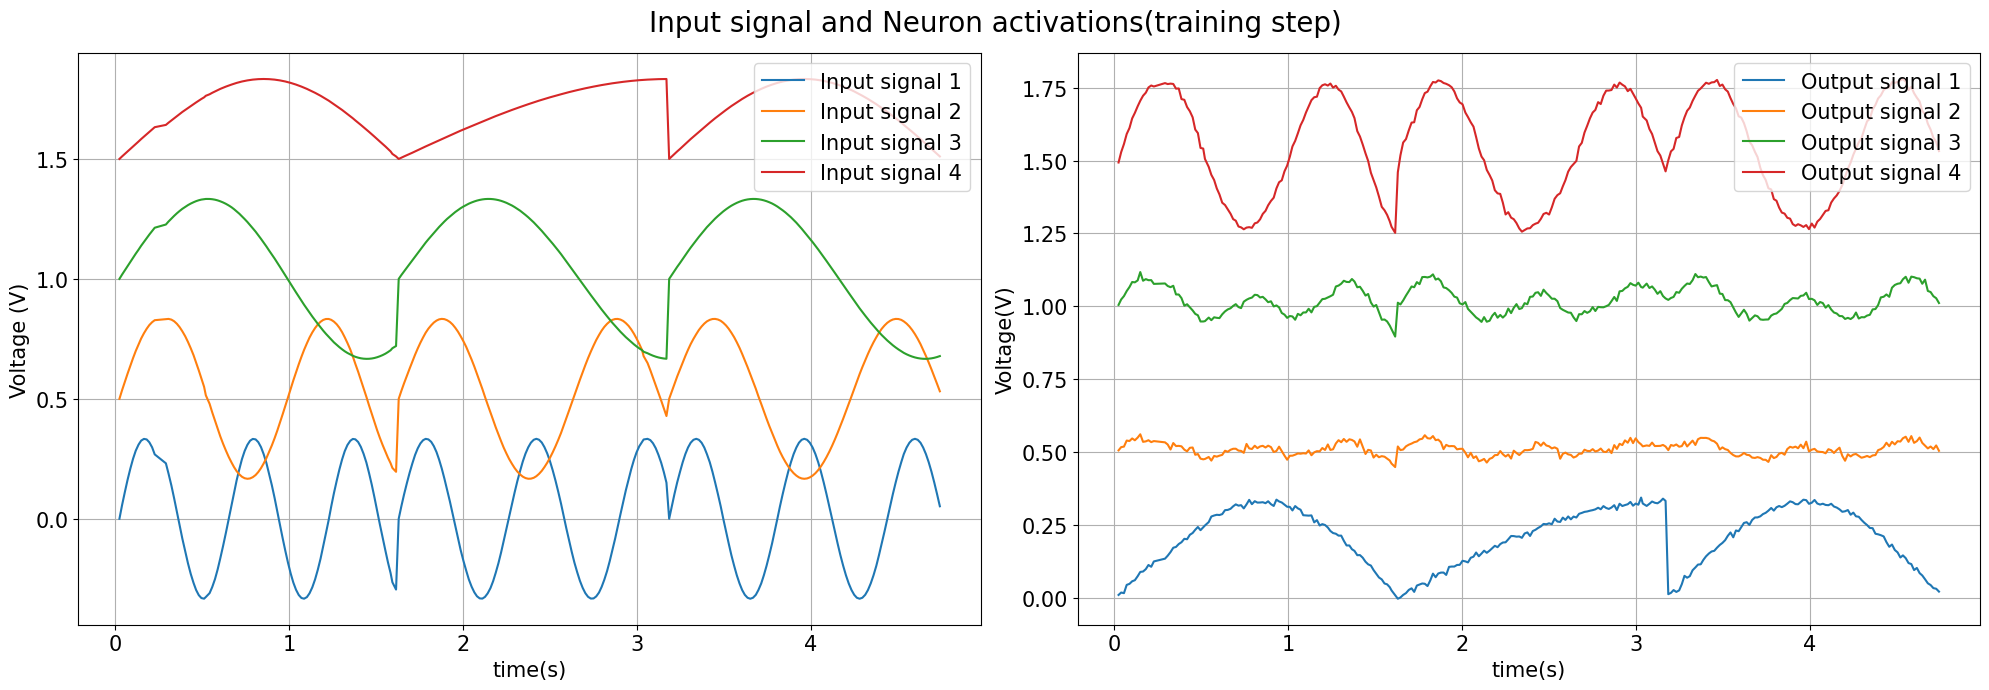

In [30]:

limit = 300
scaling_factor = 1
spacing = 0.5



fig,ax = plt.subplots(1,2,figsize=(20, 7))
fig.suptitle('Input signal and Neuron activations(training step)',fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=15)

ax[1].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ai_1_A'][0:limit]*scaling_factor),label='Output signal 1')
ax[1].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ai_2_A'][0:limit]*scaling_factor) + spacing,label='Output signal 2')
ax[1].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ai_3_A'][0:limit]*scaling_factor) + spacing*2,label='Output signal 3')
ax[1].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ai_4_A'][0:limit]*scaling_factor) + spacing*3,label='Output signal 4')

ax[1].grid()
ax[1].set_xlabel('time(s)',size=15)

ax[1].set_ylabel('Voltage(V)',size=15)
ax[1].legend(loc='upper right',fontsize=15)


ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ao_1_V'][0:limit]),label="Input signal 1")
ax[0].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ao_2_V'][0:limit]*scaling_factor) + spacing,label="Input signal 2")
ax[0].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ao_3_V'][0:limit]*scaling_factor) + spacing*2,label="Input signal 3")
ax[0].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ao_4_V'][0:limit]*scaling_factor) + spacing*3,label="Input signal 4")
ax[0].grid()
ax[0].set_xlabel('time(s)',size=15)
ax[0].set_ylabel('Voltage (V)',size=15)
ax[0].legend(loc='upper right',fontsize=15)

plt.tight_layout()
plt.savefig(f"Input_signal_and_neuron_activations_{experiment_train}.pdf",format='pdf')
plt.show()



plt.show()

In [31]:
#To build the extended state matrix(Z), we need to concatenate the reservoir states and inputs row-wise(one row bellow each other). Your dataset is already in this format(row_wise) but you need to reajust the columns.
X_train = reservoir_states_train.iloc[:,[0,1,2,3]].to_numpy()

print(X_train)

[[ 0.00893338  0.00522839  0.00458404 -0.00653093]
 [ 0.01714879  0.01634336  0.02327008  0.02906919]
 [ 0.01505467  0.01811531  0.03486831  0.05693716]
 ...
 [ 0.28519673 -0.0342378  -0.0772479  -0.22576965]
 [ 0.2162517  -0.03697627 -0.07418726 -0.20515058]
 [ 0.11186765 -0.04213104 -0.09480633 -0.19580756]]


In [32]:
#Linear regression with the train states matrix(Z) and the target matrix(Yt)(Ridge regression)

alpha = 1e-3
T_washout = 0     #discarding 10% of initial points

# drop states during the initial washout period of each time series
X_washout = X_train.reshape((u_train.shape[0], u_train.shape[1], -1))[:, T_washout:, :]
X = np.concatenate(X_washout)
Y = np.concatenate(y_train[:, T_washout:, :])
# state correlation matrix
R = X.T @ X
# state-output cross-correlation matrix
P = X.T @ Y
# ridge regression: state -> output
wout = np.linalg.inv((R + alpha * np.eye(X_train.shape[1]))) @ P


print(wout)

[[ 0.98090699  0.09374297 -0.02208341]
 [-8.36246744 -3.68857878  1.89930925]
 [ 5.38762428  3.25958585  0.58010067]
 [ 0.0933025   0.20438017  0.26014646]]


In [33]:
print(wout.shape)

(4, 3)


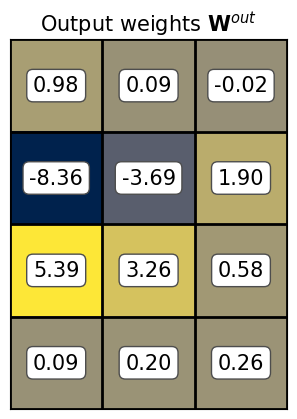

In [34]:
def plot_outuput_weigh_matrix(matrix, title=r'Output weights $\mathbf{W}^{out}$', cmap='cividis'):
    plt.imshow(matrix, cmap=cmap) # imshow


    plt.title(title,fontsize=15)
    plt.vlines([-0.5,0.5,1.5,2.5],ymax=3.5,ymin=-0.5,colors='black',linewidth=2)
    plt.hlines([-0.5,0.5,1.5,2.5,3.5],xmax=2.5,xmin=-0.5,colors='black',linewidth=2)

    plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # labels along the bottom edge are off

    # tick_marks = np.arange(len(matrix.columns))
    # plt.xticks(tick_marks, matrix.columns, rotation=45,fontsize = 15)
    # plt.yticks(tick_marks, matrix.index,fontsize = 15)
    # plt.tight_layout()
    # plt.ylabel(matrix.index.name,fontsize=15)
    # plt.xlabel(matrix.columns.name,fontsize=15)
    for (i, j), z in np.ndenumerate(matrix):
        plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)


    plt.savefig(f'wout_matrix_{experiment_train}.pdf',format='pdf')

plot_outuput_weigh_matrix(wout)

In [35]:
np.savetxt(f'weight_output_{experiment_train}.txt',delimiter='\t',X=wout)



In [36]:
#computing predicted values
y_pred_train = X_train @ wout


In [37]:
def accuracy_elementwise(ypred, ytrue):
    # compute accuracy at each time step
    yp = ypred.reshape(-1, ytrue.shape[2]).argmax(axis=1)         #argmax(axis =1) is the "winner takes all" approach from the paper "hands on Reservoir computing"
    yt = ytrue.reshape(-1, ytrue.shape[2]).argmax(axis=1)
    return np.sum(yp == yt) / yp.shape[0]



print(f'Training accuracy: {accuracy_elementwise(y_pred_train, y_train):.2%} (per time step)')

Training accuracy: 44.08% (per time step)


In [38]:
def accuracy(ypred, ytrue):
    # compute accuracy by averaging the predicted class over the whole time series
    yp = ypred.reshape(ytrue.shape).mean(axis=1).argmax(axis=1)
    yt = ytrue[:,0,:].argmax(axis=1)
    return np.sum(yp == yt) / yp.shape[0]

print(f'Training accuracy: {accuracy(y_pred_train, y_train):.2%} (per time series)')

Training accuracy: 58.33% (per time series)


Predicted   0  1   2
Actual              
0          37  0   3
1          28  3   9
2          10  0  30


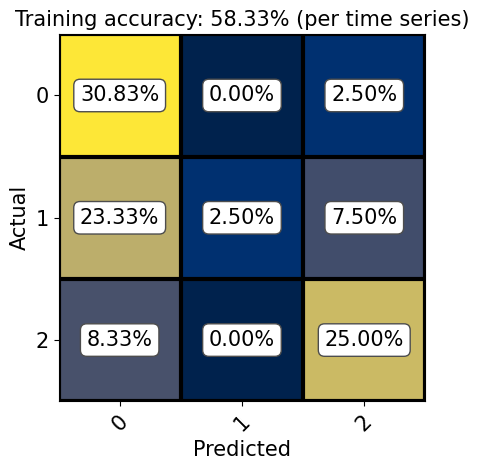

In [39]:
#printing confusion matrix



y_pred_train_series = pd.Series(y_pred_train.reshape(y_train.shape).mean(axis=1).argmax(axis=1), name='Predicted')
y_train_series = pd.Series(y_train[:,0,:].argmax(axis=1), name='Actual')


def plot_confusion_matrix_train(df_confusion, title=(f'Training accuracy: {accuracy(y_pred_train, y_train):.2%} (per time series)'), cmap='cividis'):
    if df_confusion.shape[1] == 1:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=0.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_train}.pdf',format='pdf')

    if df_confusion.shape[1] == 2:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=1.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_train}.pdf',format='pdf')


    if df_confusion.shape[1] == 3:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5,1.5,2.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=2.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_train}.pdf',format='pdf')



df_confusion = pd.crosstab(y_train_series, y_pred_train_series)
print(df_confusion)

plot_confusion_matrix_train(df_confusion*100/len(u_train))


In [40]:
u_test_signal = np.concatenate(u_test)

In [41]:
encoding = 'X5'
date_stamp = time.strftime('%Y_%m_%d')
dataset = 'iris_dataset'
sample = "7-2_6-3_8-1_5-4_FIBER_LICLO4_ELECTROLYTE_RES_CHIP_0010_CE4_#3"

experiment_test = f"{dataset}_test_states_{sample}_encoding={encoding}_{date_stamp}"


In [42]:

print(experiment_test)

iris_dataset_test_states_7-2_6-3_8-1_5-4_FIBER_LICLO4_ELECTROLYTE_RES_CHIP_0010_CE4_#3_encoding=X5_2025_02_21


In [43]:
exp_test = load_or_create_experiment(
    experiment_name=experiment_test, sample_name=sample)

In [44]:
context_meas = Measurement(exp=exp_test, name=f'{experiment_test}')
#Registering ai channels parameters
context_meas.register_parameter(ai_1_6002)
context_meas.register_parameter(ai_2_6002)
context_meas.register_parameter(ai_3_6002)
context_meas.register_parameter(ai_4_6002)
# context_meas.register_parameter(ai_5_6002)
# context_meas.register_parameter(ai_6_6002)
# context_meas.register_parameter(ai_7_6002)
context_meas.register_parameter(Ao_1)
context_meas.register_parameter(Ao_2)
context_meas.register_parameter(Ao_3)
context_meas.register_parameter(Ao_4)
# context_meas.register_parameter(entry)
context_meas.register_parameter(time_parameter)


In [45]:
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)



agilent_dual_channel.ch1.output('ON')
agilent_dual_channel.ch2.output('ON')
with context_meas.run(write_in_background=False) as datasaver:  
        time_parameter.reset_clock() 
        for i in u_test_signal:
                
              
                
                agilent_dual_channel.ch1.offset(i[0])     #Ao_1
                agilent_dual_channel.ch2.offset(i[1])     #Ao_2
                dac_ao_6001.voltage_0.set(i[2])           #Ao_3
                dac_ao_6001.voltage_1.set(i[3])           #Ao_4
                voltages = daq_ai_6002.voltage()

                now = time_parameter() 
                datasaver.add_result((Ao_1,i[0]),(Ao_2,i[1]),(Ao_3,i[2]),(Ao_4,i[3]),(ai_1_6002,voltages[0]),(ai_2_6002,voltages[1]),(ai_3_6002,voltages[2]),
                                (ai_4_6002,voltages[3]),(time_parameter,now))



                        
        dataset = datasaver.dataset
    
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)

agilent_dual_channel.ch1.output('OFF')
agilent_dual_channel.ch2.output('OFF')

Starting experimental run with id: 867. 


In [46]:
experiments()
last_run_id = dataset.captured_run_id
print(last_run_id)
reservoir_states_test=load_by_run_spec(captured_run_id=last_run_id).to_pandas_dataframe()
print(reservoir_states_test)

[iris_dataset_train_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13#no_fiber_no_electrolyte_res_chip_0006_CE_04#1@c:\Users\laboratorio20\codigos_python\fiber_experiments\reservoir_iris\reservoirs_database_iris.db
 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 1-iris_dataset_train_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13-1-Ai_1_A,Ao_4_V,Ao_3_V,Ai_2_A,Ai_4_A,time,Ai_3_A,Ao_2_V,Ao_1_V-108000,
 iris_dataset_test_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13#no_fiber_no_electrolyte_res_chip_0006_CE_04#2@c:\Users\laboratorio20\codigos_python\fiber_experiments\reservoir_iris\reservoirs_database_iris.db
 --------------------------------------------------------------------------------------------------------------------------------------------------------------------

867
        Ai_1_A    Ai_2_A    Ai_3_A    Ai_4_A    Ao_1_V    Ao_2_V    Ao_3_V  \
0     0.005067 -0.002665  0.000235 -0.011041  0.000000  0.000000  0.000000   
1     0.016666  0.011833  0.014410  0.037285  0.056278  0.038659  0.015702   
2     0.016988  0.018437  0.032291  0.059837  0.110940  0.076796  0.031369   
3     0.027942  0.032935  0.051782  0.095759  0.162417  0.113897  0.046967   
4     0.042278  0.045822  0.073046  0.128298  0.209230  0.149461  0.062460   
...        ...       ...       ...       ...       ...       ...       ...   
2995  0.327562 -0.018290 -0.026022  0.130070 -0.315362  0.151330  0.155977   
2996  0.299695 -0.041487 -0.033110  0.101075 -0.290061  0.122708  0.106981   
2997  0.246697 -0.024250 -0.033755  0.072724 -0.254824  0.092997  0.055245   
2998  0.171631 -0.036815 -0.054857  0.033419 -0.210857  0.062460  0.002094   
2999  0.088188 -0.025056 -0.037460  0.020209 -0.159666  0.031369 -0.051110   

        Ao_4_V       time  
0     0.000000   0.029468  
1  

In [47]:
reservoir_states_test.to_csv(f'{experiment_test}.txt',sep='\t',decimal='.')

In [48]:
X_test = reservoir_states_test.iloc[:,[0,1,2,3]].to_numpy()

Text(0.5, 0.98, 'Input signal and Neuron activations(testing step)')

Text(0.5, 0, 'time(s)')

Text(0, 0.5, 'Voltage(V)')

Text(0.5, 0, 'time(s)')

Text(0, 0.5, 'Voltage (V)')

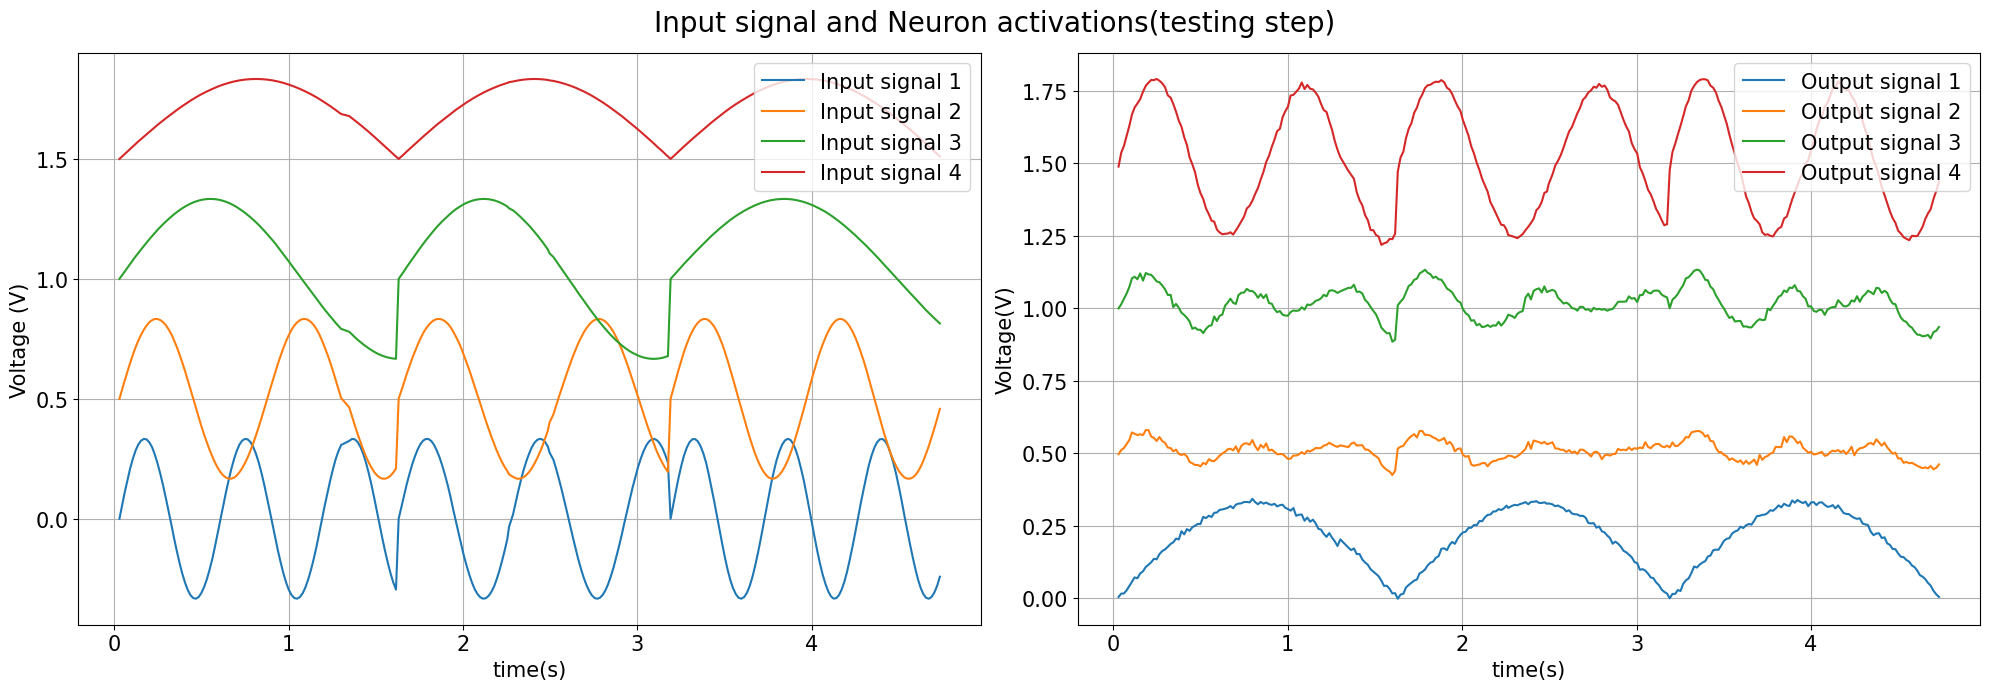

In [49]:
limit = 300
scaling_factor = 1
spacing = 0.5



fig,ax = plt.subplots(1,2,figsize=(20, 7))
fig.suptitle('Input signal and Neuron activations(testing step)',fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=15)

ax[1].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ai_1_A'][0:limit]*scaling_factor),label='Output signal 1')
ax[1].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ai_2_A'][0:limit]*scaling_factor) + spacing,label='Output signal 2')
ax[1].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ai_3_A'][0:limit]*scaling_factor) + spacing*2,label='Output signal 3')
ax[1].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ai_4_A'][0:limit]*scaling_factor) + spacing*3,label='Output signal 4')

ax[1].grid()
ax[1].set_xlabel('time(s)',size=15)

ax[1].set_ylabel('Voltage(V)',size=15)
ax[1].legend(loc='upper right',fontsize=15)


ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ao_1_V'][0:limit]),label="Input signal 1")
ax[0].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ao_2_V'][0:limit]*scaling_factor) + spacing,label="Input signal 2")
ax[0].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ao_3_V'][0:limit]*scaling_factor) + spacing*2,label="Input signal 3")
ax[0].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ao_4_V'][0:limit]*scaling_factor) + spacing*3,label="Input signal 4")
ax[0].grid()
ax[0].set_xlabel('time(s)',size=15)
ax[0].set_ylabel('Voltage (V)',size=15)
ax[0].legend(loc='upper right',fontsize=15)

plt.tight_layout()
plt.savefig(f"Input_signal_and_neuron_activations_{experiment_test}.pdf",format='pdf')
plt.show()



plt.show()


In [50]:
y_pred_test = X_test @ wout

In [51]:
print(f'Testing accuracy:  {accuracy_elementwise(y_pred_test, y_test):.2%} (per time step)')
print(f'Testing accuracy:  {accuracy(y_pred_test, y_test):.2%} (per time series)')

Testing accuracy:  41.97% (per time step)
Testing accuracy:  43.33% (per time series)


Predicted  0  2
Actual         
0          8  2
1          5  5
2          5  5


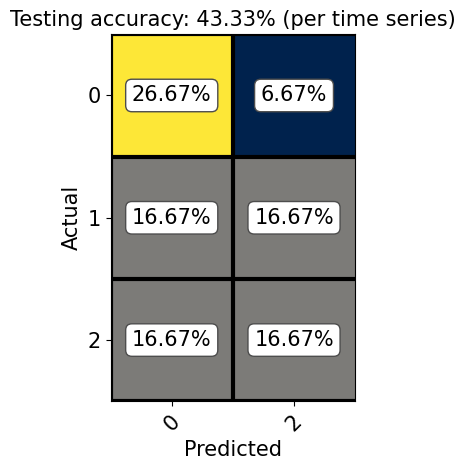

In [52]:
y_pred_test_series = pd.Series(y_pred_test.reshape(y_test.shape).mean(axis=1).argmax(axis=1), name='Predicted')
y_test_series = pd.Series(y_test[:,0,:].argmax(axis=1), name='Actual')



def plot_confusion_matrix_test(df_confusion, title=f'Testing accuracy: {accuracy(y_pred_test, y_test):.2%} (per time series)', cmap='cividis'):

    if df_confusion.shape[1] == 1:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=0.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_test}.pdf',format='pdf')

    if df_confusion.shape[1] == 2:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=1.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_test}.pdf',format='pdf')


    if df_confusion.shape[1] == 3:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5,1.5,2.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=2.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_test}.pdf',format='pdf')

        


df_confusion = pd.crosstab(y_test_series, y_pred_test_series)
print(df_confusion)



plot_confusion_matrix_test(df_confusion*100/len(u_test))

In [53]:
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)

agilent_dual_channel.ch1.output('OFF')
agilent_dual_channel.ch2.output('OFF')

In [54]:
#starting second round of encoding

In [55]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data)

iris_df['class']=iris.target

iris_df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
iris_df.dropna(how="all", inplace=True) # remove any empty lines

#selecting only first 4 columns as they are the independent(X) variable
# any kind of feature selection or correlation analysis should be first done on these

print(iris_df)

     sepal_len  sepal_wid  petal_len  petal_wid  class
0          5.1        3.5        1.4        0.2      0
1          4.9        3.0        1.4        0.2      0
2          4.7        3.2        1.3        0.2      0
3          4.6        3.1        1.5        0.2      0
4          5.0        3.6        1.4        0.2      0
..         ...        ...        ...        ...    ...
145        6.7        3.0        5.2        2.3      2
146        6.3        2.5        5.0        1.9      2
147        6.5        3.0        5.2        2.0      2
148        6.2        3.4        5.4        2.3      2
149        5.9        3.0        5.1        1.8      2

[150 rows x 5 columns]


In [56]:
# normalizing DataFrame columns between +1 and -1. Each variable column is normalized between 0 and 1.

# # Create the scaler
scaler = MinMaxScaler()

#Fit and transform the data
iris_df_one_hot_encoded = pd.get_dummies(iris_df,columns=['class'],drop_first=False,dtype='int')
iris_df_normalized = pd.DataFrame(scaler.fit_transform(iris_df_one_hot_encoded), columns=iris_df_one_hot_encoded.columns)


# arr = iris_df.iloc[0,[0,1,2,3]]

print(iris_df_normalized)


     sepal_len  sepal_wid  petal_len  petal_wid  class_0  class_1  class_2
0     0.222222   0.625000   0.067797   0.041667      1.0      0.0      0.0
1     0.166667   0.416667   0.067797   0.041667      1.0      0.0      0.0
2     0.111111   0.500000   0.050847   0.041667      1.0      0.0      0.0
3     0.083333   0.458333   0.084746   0.041667      1.0      0.0      0.0
4     0.194444   0.666667   0.067797   0.041667      1.0      0.0      0.0
..         ...        ...        ...        ...      ...      ...      ...
145   0.666667   0.416667   0.711864   0.916667      0.0      0.0      1.0
146   0.555556   0.208333   0.677966   0.750000      0.0      0.0      1.0
147   0.611111   0.416667   0.711864   0.791667      0.0      0.0      1.0
148   0.527778   0.583333   0.745763   0.916667      0.0      0.0      1.0
149   0.444444   0.416667   0.694915   0.708333      0.0      0.0      1.0

[150 rows x 7 columns]


In [57]:
iris_df_normalized = iris_df_normalized.to_numpy()
print(iris_df_normalized)


[[0.22222222 0.625      0.06779661 ... 1.         0.         0.        ]
 [0.16666667 0.41666667 0.06779661 ... 1.         0.         0.        ]
 [0.11111111 0.5        0.05084746 ... 1.         0.         0.        ]
 ...
 [0.61111111 0.41666667 0.71186441 ... 0.         0.         1.        ]
 [0.52777778 0.58333333 0.74576271 ... 0.         0.         1.        ]
 [0.44444444 0.41666667 0.69491525 ... 0.         0.         1.        ]]


In [58]:
# iris_df_normalized_one_hot_encoded = iris_df_normalized_one_hot_encoded.to_numpy()

timesteps = np.arange(0,1,0.01)

u = np.array([ np.vstack([(np.sin(timesteps*(np.pi)*pt[i]))/3 for i in range(4)]).T
    for pt in iris_df_normalized[:,:4]
])
y = np.array([iris_df_normalized[:,4:]] * len(timesteps)).swapaxes(0, 1)



In [59]:
#splitting data in train and test sets
u_train = u[train_idxs]
y_train = y[train_idxs]
u_test = u[test_idxs]
y_test = y[test_idxs]


print(train_idxs)
print(test_idxs)

[20, 9, 25, 41, 3, 4, 34, 6, 23, 37, 45, 32, 13, 2, 5, 27, 26, 44, 15, 36, 17, 40, 1, 33, 18, 39, 7, 49, 22, 47, 43, 21, 12, 19, 46, 0, 8, 30, 38, 42, 59, 84, 57, 86, 69, 85, 93, 61, 56, 87, 96, 62, 73, 91, 94, 54, 53, 63, 81, 71, 67, 82, 74, 60, 64, 68, 75, 92, 99, 97, 55, 70, 52, 80, 65, 90, 95, 72, 77, 98, 138, 104, 107, 132, 126, 110, 121, 109, 131, 145, 102, 148, 135, 136, 120, 143, 122, 141, 129, 139, 140, 130, 108, 115, 133, 134, 128, 101, 142, 137, 118, 114, 124, 112, 111, 100, 147, 105, 123, 117]
[10, 11, 14, 16, 24, 28, 29, 31, 35, 48, 50, 51, 58, 66, 76, 78, 79, 83, 88, 89, 103, 106, 113, 116, 119, 125, 127, 144, 146, 149]


In [60]:
encoding = 'MinMaxScaler'
date_stamp = time.strftime('%Y_%m_%d')
dataset = 'iris_dataset'

sample = "7-2_6-3_8-1_5-4_FIBER_LICLO4_ELECTROLYTE_RES_CHIP_0010_CE4_#3"


experiment_train =  f"{dataset}_train_states_{sample}_encoding={encoding}_{date_stamp}"

In [61]:
exp_train = load_or_create_experiment(
    experiment_name=experiment_train, sample_name=sample)

In [62]:
context_meas = Measurement(exp=exp_train, name=f'{experiment_train}')
#Registering ai channels parameters
context_meas.register_parameter(ai_1_6002)
context_meas.register_parameter(ai_2_6002)
context_meas.register_parameter(ai_3_6002)
context_meas.register_parameter(ai_4_6002)

context_meas.register_parameter(Ao_1)
context_meas.register_parameter(Ao_2)
context_meas.register_parameter(Ao_3)
context_meas.register_parameter(Ao_4)
context_meas.register_parameter(time_parameter)

In [63]:
#concatenating input signals to generate the whole time series of four inputs
u_train_signal = np.concatenate(u_train)

print(u_train_signal)

[[0.         0.         0.         0.        ]
 [0.00319972 0.00610831 0.00124243 0.00043633]
 [0.00639915 0.01221457 0.00248485 0.00087266]
 ...
 [0.08683484 0.2517606  0.06542174 0.15249532]
 [0.0772493  0.2465437  0.05547291 0.14429086]
 [0.06759577 0.24118993 0.04547298 0.13597737]]


In [64]:
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)



agilent_dual_channel.ch1.output('ON')
agilent_dual_channel.ch2.output('ON')
with context_meas.run(write_in_background=False) as datasaver:
        time_parameter.reset_clock() 
        for i in u_train_signal:
              
                
                agilent_dual_channel.ch1.offset(i[0])     #Ao_1
                agilent_dual_channel.ch2.offset(i[1])     #Ao_2
                dac_ao_6001.voltage_0.set(i[2])           #Ao_3
                dac_ao_6001.voltage_1.set(i[3])           #Ao_4
                voltages = daq_ai_6002.voltage()

                now = time_parameter() 
                datasaver.add_result((Ao_1,i[0]),(Ao_2,i[1]),(Ao_3,i[2]),(Ao_4,i[3]),(ai_1_6002,voltages[0]),(ai_2_6002,voltages[1]),(ai_3_6002,voltages[2]),
                                (ai_4_6002,voltages[3]),(time_parameter,now))



                        
        dataset = datasaver.dataset

    
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)

agilent_dual_channel.ch1.output('OFF')
agilent_dual_channel.ch2.output('OFF')

Starting experimental run with id: 868. 


In [65]:
agilent_dual_channel.ch1.output('OFF')
agilent_dual_channel.ch2.output('OFF')
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)

In [66]:
experiments()
last_run_id = dataset.captured_run_id
print(last_run_id)
reservoir_states_train=load_by_run_spec(captured_run_id=last_run_id).to_pandas_dataframe()
print(reservoir_states_test)

[iris_dataset_train_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13#no_fiber_no_electrolyte_res_chip_0006_CE_04#1@c:\Users\laboratorio20\codigos_python\fiber_experiments\reservoir_iris\reservoirs_database_iris.db
 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 1-iris_dataset_train_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13-1-Ai_1_A,Ao_4_V,Ao_3_V,Ai_2_A,Ai_4_A,time,Ai_3_A,Ao_2_V,Ao_1_V-108000,
 iris_dataset_test_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13#no_fiber_no_electrolyte_res_chip_0006_CE_04#2@c:\Users\laboratorio20\codigos_python\fiber_experiments\reservoir_iris\reservoirs_database_iris.db
 --------------------------------------------------------------------------------------------------------------------------------------------------------------------

868
        Ai_1_A    Ai_2_A    Ai_3_A    Ai_4_A    Ao_1_V    Ao_2_V    Ao_3_V  \
0     0.005067 -0.002665  0.000235 -0.011041  0.000000  0.000000  0.000000   
1     0.016666  0.011833  0.014410  0.037285  0.056278  0.038659  0.015702   
2     0.016988  0.018437  0.032291  0.059837  0.110940  0.076796  0.031369   
3     0.027942  0.032935  0.051782  0.095759  0.162417  0.113897  0.046967   
4     0.042278  0.045822  0.073046  0.128298  0.209230  0.149461  0.062460   
...        ...       ...       ...       ...       ...       ...       ...   
2995  0.327562 -0.018290 -0.026022  0.130070 -0.315362  0.151330  0.155977   
2996  0.299695 -0.041487 -0.033110  0.101075 -0.290061  0.122708  0.106981   
2997  0.246697 -0.024250 -0.033755  0.072724 -0.254824  0.092997  0.055245   
2998  0.171631 -0.036815 -0.054857  0.033419 -0.210857  0.062460  0.002094   
2999  0.088188 -0.025056 -0.037460  0.020209 -0.159666  0.031369 -0.051110   

        Ao_4_V       time  
0     0.000000   0.029468  
1  

In [67]:
reservoir_states_train.to_csv(f'{experiment_train}.txt',sep='\t',decimal='.')

In [68]:
print(reservoir_states_train)


         Ai_1_A    Ai_2_A    Ai_3_A    Ai_4_A    Ao_1_V    Ao_2_V    Ao_3_V  \
0      0.000718 -0.009430 -0.006531 -0.006531  0.000000  0.000000  0.000000   
1      0.018921  0.009417  0.002973  0.010222  0.003200  0.006108  0.001242   
2     -0.000410 -0.005242  0.000557  0.005067  0.006399  0.012215  0.002485   
3     -0.002343 -0.013297 -0.020545  0.007323  0.009598  0.018317  0.003727   
4     -0.003631  0.011672  0.017149  0.020532  0.012796  0.024413  0.004970   
...         ...       ...       ...       ...       ...       ...       ...   
11995  0.170664  0.029391  0.064508  0.229622  0.105768  0.261772  0.085130   
11996  0.153911  0.018921  0.056454  0.214641  0.096344  0.256838  0.075310   
11997  0.154556  0.020371  0.059676  0.204331  0.086835  0.251761  0.065422   
11998  0.143602  0.028747  0.072563  0.215124  0.077249  0.246544  0.055473   
11999  0.135708  0.020371  0.044856  0.207875  0.067596  0.241190  0.045473   

         Ao_4_V        time  
0      0.000000    0.

Text(0.5, 0.98, 'Input signal and Neuron activations(training step)')

Text(0.5, 0, 'time(s)')

Text(0, 0.5, 'Voltage(V)')

Text(0.5, 0, 'time(s)')

Text(0, 0.5, 'Voltage (V)')

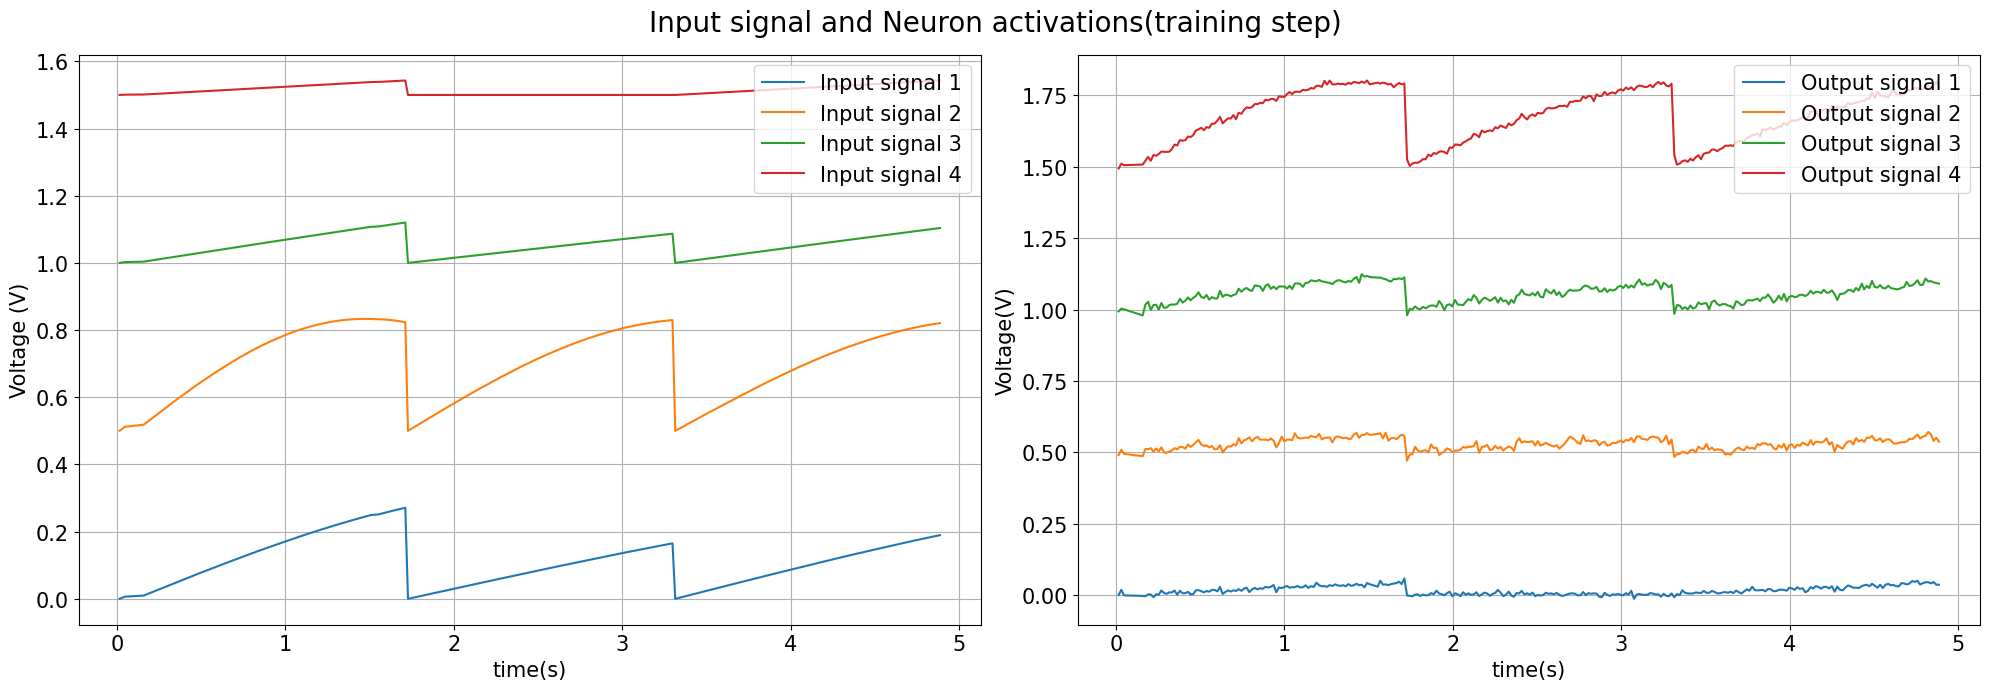

In [69]:

limit = 300
scaling_factor = 1
spacing = 0.5



fig,ax = plt.subplots(1,2,figsize=(20, 7))
fig.suptitle('Input signal and Neuron activations(training step)',fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=15)

ax[1].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ai_1_A'][0:limit]*scaling_factor),label='Output signal 1')
ax[1].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ai_2_A'][0:limit]*scaling_factor) + spacing,label='Output signal 2')
ax[1].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ai_3_A'][0:limit]*scaling_factor) + spacing*2,label='Output signal 3')
ax[1].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ai_4_A'][0:limit]*scaling_factor) + spacing*3,label='Output signal 4')

ax[1].grid()
ax[1].set_xlabel('time(s)',size=15)

ax[1].set_ylabel('Voltage(V)',size=15)
ax[1].legend(loc='upper right',fontsize=15)


ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ao_1_V'][0:limit]),label="Input signal 1")
ax[0].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ao_2_V'][0:limit]*scaling_factor) + spacing,label="Input signal 2")
ax[0].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ao_3_V'][0:limit]*scaling_factor) + spacing*2,label="Input signal 3")
ax[0].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ao_4_V'][0:limit]*scaling_factor) + spacing*3,label="Input signal 4")
ax[0].grid()
ax[0].set_xlabel('time(s)',size=15)
ax[0].set_ylabel('Voltage (V)',size=15)
ax[0].legend(loc='upper right',fontsize=15)

plt.tight_layout()
plt.savefig(f"Input_signal_and_neuron_activations_{experiment_train}.pdf",format='pdf')
plt.show()



plt.show()

In [70]:
#To build the extended state matrix(Z), we need to concatenate the reservoir states and inputs row-wise(one row bellow each other). Your dataset is already in this format(row_wise) but you need to reajust the columns.
X_train = reservoir_states_train.iloc[:,[0,1,2,3]].to_numpy()

print(X_train)

[[ 0.00071797 -0.00943048 -0.00653093 -0.00653093]
 [ 0.01892074  0.00941664  0.00297318  0.01022207]
 [-0.00040964 -0.00524223  0.00055688  0.0050673 ]
 ...
 [ 0.15455557  0.02037052  0.05967563  0.2043313 ]
 [ 0.14360169  0.02874702  0.07256255  0.2151241 ]
 [ 0.13570845  0.02037052  0.04485567  0.20787521]]


In [71]:
#Linear regression with the train states matrix(Z) and the target matrix(Yt)(Ridge regression)

alpha = 1e-3
T_washout = 0     #discarding 10% of initial points

# drop states during the initial washout period of each time series
X_washout = X_train.reshape((u_train.shape[0], u_train.shape[1], -1))[:, T_washout:, :]
X = np.concatenate(X_washout)
Y = np.concatenate(y_train[:, T_washout:, :])
# state correlation matrix
R = X.T @ X
# state-output cross-correlation matrix
P = X.T @ Y
# ridge regression: state -> output
wout = np.linalg.inv((R + alpha * np.eye(X_train.shape[1]))) @ P


print(wout)

[[-2.36216423  2.29277635  1.79373109]
 [ 3.90764491  1.68500907 -8.1218064 ]
 [-3.36990778 -2.22476837  5.39320543]
 [ 4.38786053 -0.12726632 -0.40740796]]


In [72]:
print(wout.shape)

(4, 3)


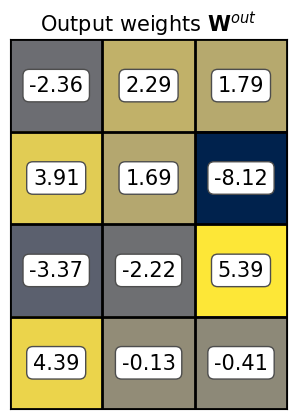

In [73]:
def plot_outuput_weigh_matrix(matrix, title=r'Output weights $\mathbf{W}^{out}$', cmap='cividis'):
    plt.imshow(matrix, cmap=cmap) # imshow


    plt.title(title,fontsize=15)
    plt.vlines([-0.5,0.5,1.5,2.5],ymax=3.5,ymin=-0.5,colors='black',linewidth=2)
    plt.hlines([-0.5,0.5,1.5,2.5,3.5],xmax=2.5,xmin=-0.5,colors='black',linewidth=2)

    plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # labels along the bottom edge are off

    # tick_marks = np.arange(len(matrix.columns))
    # plt.xticks(tick_marks, matrix.columns, rotation=45,fontsize = 15)
    # plt.yticks(tick_marks, matrix.index,fontsize = 15)
    # plt.tight_layout()
    # plt.ylabel(matrix.index.name,fontsize=15)
    # plt.xlabel(matrix.columns.name,fontsize=15)
    for (i, j), z in np.ndenumerate(matrix):
        plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)


    plt.savefig(f'wout_matrix_{experiment_train}.pdf',format='pdf')

plot_outuput_weigh_matrix(wout)

In [74]:
np.savetxt(f'weight_output_{experiment_train}.txt',delimiter='\t',X=wout)



In [75]:
#computing predicted values
y_pred_train = X_train @ wout


In [76]:
def accuracy_elementwise(ypred, ytrue):
    # compute accuracy at each time step
    yp = ypred.reshape(-1, ytrue.shape[2]).argmax(axis=1)         #argmax(axis =1) is the "winner takes all" approach from the paper "hands on Reservoir computing"
    yt = ytrue.reshape(-1, ytrue.shape[2]).argmax(axis=1)
    return np.sum(yp == yt) / yp.shape[0]



print(f'Training accuracy: {accuracy_elementwise(y_pred_train, y_train):.2%} (per time step)')

Training accuracy: 65.72% (per time step)


In [77]:
def accuracy(ypred, ytrue):
    # compute accuracy by averaging the predicted class over the whole time series
    yp = ypred.reshape(ytrue.shape).mean(axis=1).argmax(axis=1)
    yt = ytrue[:,0,:].argmax(axis=1)
    return np.sum(yp == yt) / yp.shape[0]

print(f'Training accuracy: {accuracy(y_pred_train, y_train):.2%} (per time series)')

Training accuracy: 71.67% (per time series)


Predicted   0  1   2
Actual              
0          40  0   0
1           0  6  34
2           0  0  40


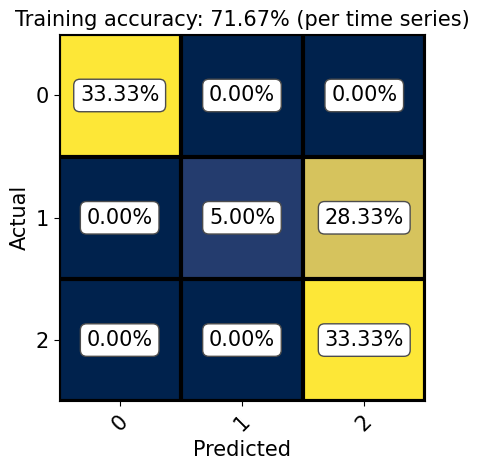

In [78]:
#printing confusion matrix



y_pred_train_series = pd.Series(y_pred_train.reshape(y_train.shape).mean(axis=1).argmax(axis=1), name='Predicted')
y_train_series = pd.Series(y_train[:,0,:].argmax(axis=1), name='Actual')


def plot_confusion_matrix_train(df_confusion, title=(f'Training accuracy: {accuracy(y_pred_train, y_train):.2%} (per time series)'), cmap='cividis'):
    if df_confusion.shape[1] == 1:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=0.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_train}.pdf',format='pdf')

    if df_confusion.shape[1] == 2:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=1.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_train}.pdf',format='pdf')


    if df_confusion.shape[1] == 3:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5,1.5,2.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=2.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_train}.pdf',format='pdf')



df_confusion = pd.crosstab(y_train_series, y_pred_train_series)
print(df_confusion)

plot_confusion_matrix_train(df_confusion*100/len(u_train))


In [79]:
u_test_signal = np.concatenate(u_test)

In [80]:
encoding = 'MinMaxScaler'
date_stamp = time.strftime('%Y_%m_%d')
dataset = 'iris_dataset'

sample = "7-2_6-3_8-1_5-4_FIBER_LICLO4_ELECTROLYTE_RES_CHIP_0010_CE4_#3"


experiment_test = f"{dataset}_test_states_{sample}_encoding={encoding}_{date_stamp}"


In [81]:

print(experiment_test)

iris_dataset_test_states_7-2_6-3_8-1_5-4_FIBER_LICLO4_ELECTROLYTE_RES_CHIP_0010_CE4_#3_encoding=MinMaxScaler_2025_02_21


In [82]:
exp_test = load_or_create_experiment(
    experiment_name=experiment_test, sample_name=sample)

In [83]:
context_meas = Measurement(exp=exp_test, name=f'{experiment_test}')
#Registering ai channels parameters
context_meas.register_parameter(ai_1_6002)
context_meas.register_parameter(ai_2_6002)
context_meas.register_parameter(ai_3_6002)
context_meas.register_parameter(ai_4_6002)
# context_meas.register_parameter(ai_5_6002)
# context_meas.register_parameter(ai_6_6002)
# context_meas.register_parameter(ai_7_6002)
context_meas.register_parameter(Ao_1)
context_meas.register_parameter(Ao_2)
context_meas.register_parameter(Ao_3)
context_meas.register_parameter(Ao_4)
# context_meas.register_parameter(entry)
context_meas.register_parameter(time_parameter)


In [84]:
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)



agilent_dual_channel.ch1.output('ON')
agilent_dual_channel.ch2.output('ON')
with context_meas.run(write_in_background=False) as datasaver:  
        time_parameter.reset_clock() 
        for i in u_test_signal:
                
              
                
                agilent_dual_channel.ch1.offset(i[0])     #Ao_1
                agilent_dual_channel.ch2.offset(i[1])     #Ao_2
                dac_ao_6001.voltage_0.set(i[2])           #Ao_3
                dac_ao_6001.voltage_1.set(i[3])           #Ao_4
                voltages = daq_ai_6002.voltage()

                now = time_parameter() 
                datasaver.add_result((Ao_1,i[0]),(Ao_2,i[1]),(Ao_3,i[2]),(Ao_4,i[3]),(ai_1_6002,voltages[0]),(ai_2_6002,voltages[1]),(ai_3_6002,voltages[2]),
                                (ai_4_6002,voltages[3]),(time_parameter,now))



                        
        dataset = datasaver.dataset
    
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)

agilent_dual_channel.ch1.output('OFF')
agilent_dual_channel.ch2.output('OFF')

Starting experimental run with id: 869. 


In [85]:
experiments()
last_run_id = dataset.captured_run_id
print(last_run_id)
reservoir_states_test=load_by_run_spec(captured_run_id=last_run_id).to_pandas_dataframe()
print(reservoir_states_test)

[iris_dataset_train_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13#no_fiber_no_electrolyte_res_chip_0006_CE_04#1@c:\Users\laboratorio20\codigos_python\fiber_experiments\reservoir_iris\reservoirs_database_iris.db
 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 1-iris_dataset_train_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13-1-Ai_1_A,Ao_4_V,Ao_3_V,Ai_2_A,Ai_4_A,time,Ai_3_A,Ao_2_V,Ao_1_V-108000,
 iris_dataset_test_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13#no_fiber_no_electrolyte_res_chip_0006_CE_04#2@c:\Users\laboratorio20\codigos_python\fiber_experiments\reservoir_iris\reservoirs_database_iris.db
 --------------------------------------------------------------------------------------------------------------------------------------------------------------------

869
        Ai_1_A    Ai_2_A    Ai_3_A    Ai_4_A    Ao_1_V    Ao_2_V    Ao_3_V  \
0     0.002329  0.005712  0.000235 -0.001215  0.000000  0.000000  0.000000   
1    -0.006209 -0.002987 -0.000087  0.006034  0.003200  0.007417  0.000887   
2     0.008289  0.005228  0.005873  0.020048  0.006399  0.014830  0.001775   
3     0.004262  0.010866  0.016021  0.021015  0.009598  0.022236  0.002662   
4     0.003295  0.013444  0.014571  0.029230  0.012796  0.029631  0.003550   
...        ...       ...       ...       ...       ...       ...       ...   
2995  0.280686  0.049688  0.103813  0.266027  0.323432  0.315643  0.292017   
2996  0.279075  0.048561  0.124593  0.277787  0.324526  0.317019  0.288438   
2997  0.279075  0.052266  0.113156  0.275854  0.325557  0.318340  0.284722   
2998  0.275370  0.058870  0.103169  0.281008  0.326525  0.319607  0.280871   
2999  0.258295  0.034385  0.095920  0.271182  0.327429  0.320818  0.276885   

        Ao_4_V       time  
0     0.000000   0.024963  
1  

In [86]:
reservoir_states_test.to_csv(f'{experiment_test}.txt',sep='\t',decimal='.')

In [87]:
X_test = reservoir_states_test.iloc[:,[0,1,2,3]].to_numpy()

Text(0.5, 0.98, 'Input signal and Neuron activations(testing step)')

Text(0.5, 0, 'time(s)')

Text(0, 0.5, 'Voltage(V)')

Text(0.5, 0, 'time(s)')

Text(0, 0.5, 'Voltage (V)')

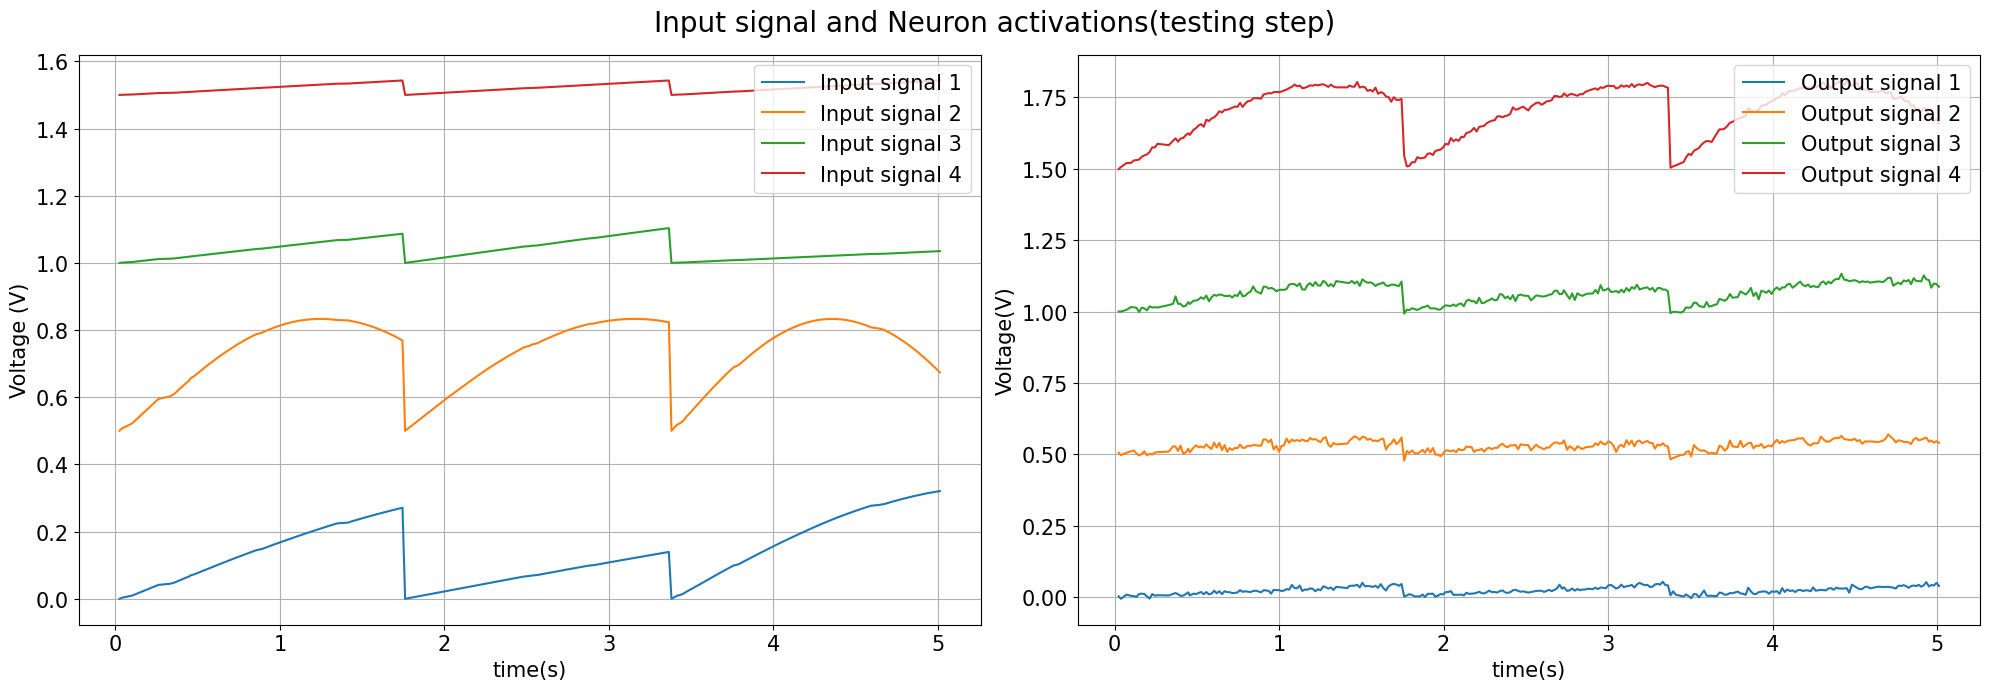

In [88]:
limit = 300
scaling_factor = 1
spacing = 0.5



fig,ax = plt.subplots(1,2,figsize=(20, 7))
fig.suptitle('Input signal and Neuron activations(testing step)',fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=15)

ax[1].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ai_1_A'][0:limit]*scaling_factor),label='Output signal 1')
ax[1].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ai_2_A'][0:limit]*scaling_factor) + spacing,label='Output signal 2')
ax[1].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ai_3_A'][0:limit]*scaling_factor) + spacing*2,label='Output signal 3')
ax[1].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ai_4_A'][0:limit]*scaling_factor) + spacing*3,label='Output signal 4')

ax[1].grid()
ax[1].set_xlabel('time(s)',size=15)

ax[1].set_ylabel('Voltage(V)',size=15)
ax[1].legend(loc='upper right',fontsize=15)


ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ao_1_V'][0:limit]),label="Input signal 1")
ax[0].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ao_2_V'][0:limit]*scaling_factor) + spacing,label="Input signal 2")
ax[0].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ao_3_V'][0:limit]*scaling_factor) + spacing*2,label="Input signal 3")
ax[0].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ao_4_V'][0:limit]*scaling_factor) + spacing*3,label="Input signal 4")
ax[0].grid()
ax[0].set_xlabel('time(s)',size=15)
ax[0].set_ylabel('Voltage (V)',size=15)
ax[0].legend(loc='upper right',fontsize=15)

plt.tight_layout()
plt.savefig(f"Input_signal_and_neuron_activations_{experiment_test}.pdf",format='pdf')
plt.show()



plt.show()


In [89]:
y_pred_test = X_test @ wout

In [90]:
print(f'Testing accuracy:  {accuracy_elementwise(y_pred_test, y_test):.2%} (per time step)')
print(f'Testing accuracy:  {accuracy(y_pred_test, y_test):.2%} (per time series)')

Testing accuracy:  61.40% (per time step)
Testing accuracy:  63.33% (per time series)


Predicted   0  1   2
Actual              
0          10  0   0
1           0  0  10
2           0  1   9


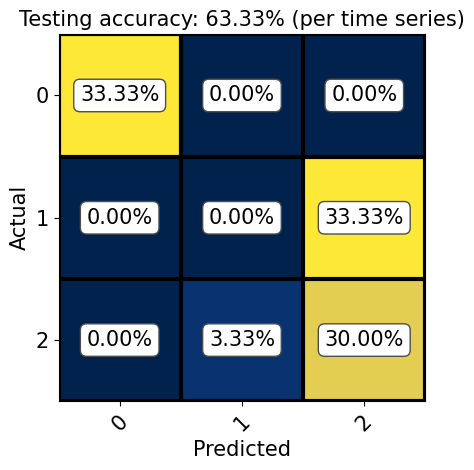

In [91]:
y_pred_test_series = pd.Series(y_pred_test.reshape(y_test.shape).mean(axis=1).argmax(axis=1), name='Predicted')
y_test_series = pd.Series(y_test[:,0,:].argmax(axis=1), name='Actual')



def plot_confusion_matrix_test(df_confusion, title=f'Testing accuracy: {accuracy(y_pred_test, y_test):.2%} (per time series)', cmap='cividis'):

    if df_confusion.shape[1] == 1:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=0.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_test}.pdf',format='pdf')

    if df_confusion.shape[1] == 2:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=1.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_test}.pdf',format='pdf')


    if df_confusion.shape[1] == 3:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5,1.5,2.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=2.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_test}.pdf',format='pdf')

        


df_confusion = pd.crosstab(y_test_series, y_pred_test_series)
print(df_confusion)



plot_confusion_matrix_test(df_confusion*100/len(u_test))

In [92]:
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)

agilent_dual_channel.ch1.output('OFF')
agilent_dual_channel.ch2.output('OFF')

In [93]:
#starting third round of encoding(No encoding, raw data)

In [94]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data)

iris_df['class']=iris.target

iris_df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
iris_df.dropna(how="all", inplace=True) # remove any empty lines

#selecting only first 4 columns as they are the independent(X) variable
# any kind of feature selection or correlation analysis should be first done on these

print(iris_df)

     sepal_len  sepal_wid  petal_len  petal_wid  class
0          5.1        3.5        1.4        0.2      0
1          4.9        3.0        1.4        0.2      0
2          4.7        3.2        1.3        0.2      0
3          4.6        3.1        1.5        0.2      0
4          5.0        3.6        1.4        0.2      0
..         ...        ...        ...        ...    ...
145        6.7        3.0        5.2        2.3      2
146        6.3        2.5        5.0        1.9      2
147        6.5        3.0        5.2        2.0      2
148        6.2        3.4        5.4        2.3      2
149        5.9        3.0        5.1        1.8      2

[150 rows x 5 columns]


In [95]:

#Fit and transform the data
iris_df_one_hot_encoded = pd.get_dummies(iris_df,columns=['class'],drop_first=False,dtype='int')
print(iris_df_one_hot_encoded)


     sepal_len  sepal_wid  petal_len  petal_wid  class_0  class_1  class_2
0          5.1        3.5        1.4        0.2        1        0        0
1          4.9        3.0        1.4        0.2        1        0        0
2          4.7        3.2        1.3        0.2        1        0        0
3          4.6        3.1        1.5        0.2        1        0        0
4          5.0        3.6        1.4        0.2        1        0        0
..         ...        ...        ...        ...      ...      ...      ...
145        6.7        3.0        5.2        2.3        0        0        1
146        6.3        2.5        5.0        1.9        0        0        1
147        6.5        3.0        5.2        2.0        0        0        1
148        6.2        3.4        5.4        2.3        0        0        1
149        5.9        3.0        5.1        1.8        0        0        1

[150 rows x 7 columns]


In [96]:
iris_df_one_hot_encoded = iris_df_one_hot_encoded.to_numpy()
print(iris_df_one_hot_encoded)


[[5.1 3.5 1.4 ... 1.  0.  0. ]
 [4.9 3.  1.4 ... 1.  0.  0. ]
 [4.7 3.2 1.3 ... 1.  0.  0. ]
 ...
 [6.5 3.  5.2 ... 0.  0.  1. ]
 [6.2 3.4 5.4 ... 0.  0.  1. ]
 [5.9 3.  5.1 ... 0.  0.  1. ]]


In [97]:
# iris_df_normalized_one_hot_encoded = iris_df_normalized_one_hot_encoded.to_numpy()

timesteps = np.arange(0,1,0.01)

u = np.array([ np.vstack([(np.sin(timesteps*(np.pi)*pt[i]))/3 for i in range(4)]).T
    for pt in iris_df_one_hot_encoded[:,:4]
])
y = np.array([iris_df_one_hot_encoded[:,4:]] * len(timesteps)).swapaxes(0, 1)



In [98]:
#splitting data in train and test sets
u_train = u[train_idxs]
y_train = y[train_idxs]
u_test = u[test_idxs]
y_test = y[test_idxs]

print(train_idxs)
print(test_idxs)

[20, 9, 25, 41, 3, 4, 34, 6, 23, 37, 45, 32, 13, 2, 5, 27, 26, 44, 15, 36, 17, 40, 1, 33, 18, 39, 7, 49, 22, 47, 43, 21, 12, 19, 46, 0, 8, 30, 38, 42, 59, 84, 57, 86, 69, 85, 93, 61, 56, 87, 96, 62, 73, 91, 94, 54, 53, 63, 81, 71, 67, 82, 74, 60, 64, 68, 75, 92, 99, 97, 55, 70, 52, 80, 65, 90, 95, 72, 77, 98, 138, 104, 107, 132, 126, 110, 121, 109, 131, 145, 102, 148, 135, 136, 120, 143, 122, 141, 129, 139, 140, 130, 108, 115, 133, 134, 128, 101, 142, 137, 118, 114, 124, 112, 111, 100, 147, 105, 123, 117]
[10, 11, 14, 16, 24, 28, 29, 31, 35, 48, 50, 51, 58, 66, 76, 78, 79, 83, 88, 89, 103, 106, 113, 116, 119, 125, 127, 144, 146, 149]


In [99]:
encoding = 'No_Encoding'
date_stamp = time.strftime('%Y_%m_%d')
dataset = 'iris_dataset'

sample = "7-2_6-3_8-1_5-4_FIBER_LICLO4_ELECTROLYTE_RES_CHIP_0010_CE4_#3"
experiment_train =  f"{dataset}_train_states_{sample}_encoding={encoding}_{date_stamp}"

In [100]:
exp_train = load_or_create_experiment(
    experiment_name=experiment_train, sample_name=sample)

In [101]:
context_meas = Measurement(exp=exp_train, name=f'{experiment_train}')
#Registering ai channels parameters
context_meas.register_parameter(ai_1_6002)
context_meas.register_parameter(ai_2_6002)
context_meas.register_parameter(ai_3_6002)
context_meas.register_parameter(ai_4_6002)

context_meas.register_parameter(Ao_1)
context_meas.register_parameter(Ao_2)
context_meas.register_parameter(Ao_3)
context_meas.register_parameter(Ao_4)
context_meas.register_parameter(time_parameter)

In [102]:
#concatenating input signals to generate the whole time series of four inputs
u_train_signal = np.concatenate(u_train)

print(u_train_signal)

[[ 0.          0.          0.          0.        ]
 [ 0.05627781  0.03553705  0.0177939   0.00209438]
 [ 0.11093985  0.07066904  0.03553705  0.00418868]
 ...
 [-0.3317538  -0.27802614  0.33333169  0.13621636]
 [-0.32985871 -0.2541475   0.32619363  0.15690131]
 [-0.30875525 -0.22665113  0.30465696  0.17683706]]


In [103]:
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)



agilent_dual_channel.ch1.output('ON')
agilent_dual_channel.ch2.output('ON')
with context_meas.run(write_in_background=False) as datasaver:
        time_parameter.reset_clock() 
        for i in u_train_signal:
              
                
                agilent_dual_channel.ch1.offset(i[0])     #Ao_1
                agilent_dual_channel.ch2.offset(i[1])     #Ao_2
                dac_ao_6001.voltage_0.set(i[2])           #Ao_3
                dac_ao_6001.voltage_1.set(i[3])           #Ao_4
                voltages = daq_ai_6002.voltage()

                now = time_parameter() 
                datasaver.add_result((Ao_1,i[0]),(Ao_2,i[1]),(Ao_3,i[2]),(Ao_4,i[3]),(ai_1_6002,voltages[0]),(ai_2_6002,voltages[1]),(ai_3_6002,voltages[2]),
                                (ai_4_6002,voltages[3]),(time_parameter,now))



                        
        dataset = datasaver.dataset

    
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)

agilent_dual_channel.ch1.output('OFF')
agilent_dual_channel.ch2.output('OFF')

Starting experimental run with id: 870. 


In [104]:
agilent_dual_channel.ch1.output('OFF')
agilent_dual_channel.ch2.output('OFF')
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)

In [105]:
experiments()
last_run_id = dataset.captured_run_id
print(last_run_id)
reservoir_states_train=load_by_run_spec(captured_run_id=last_run_id).to_pandas_dataframe()
print(reservoir_states_test)

[iris_dataset_train_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13#no_fiber_no_electrolyte_res_chip_0006_CE_04#1@c:\Users\laboratorio20\codigos_python\fiber_experiments\reservoir_iris\reservoirs_database_iris.db
 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 1-iris_dataset_train_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13-1-Ai_1_A,Ao_4_V,Ao_3_V,Ai_2_A,Ai_4_A,time,Ai_3_A,Ao_2_V,Ao_1_V-108000,
 iris_dataset_test_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13#no_fiber_no_electrolyte_res_chip_0006_CE_04#2@c:\Users\laboratorio20\codigos_python\fiber_experiments\reservoir_iris\reservoirs_database_iris.db
 --------------------------------------------------------------------------------------------------------------------------------------------------------------------

870
        Ai_1_A    Ai_2_A    Ai_3_A    Ai_4_A    Ao_1_V    Ao_2_V    Ao_3_V  \
0     0.002329  0.005712  0.000235 -0.001215  0.000000  0.000000  0.000000   
1    -0.006209 -0.002987 -0.000087  0.006034  0.003200  0.007417  0.000887   
2     0.008289  0.005228  0.005873  0.020048  0.006399  0.014830  0.001775   
3     0.004262  0.010866  0.016021  0.021015  0.009598  0.022236  0.002662   
4     0.003295  0.013444  0.014571  0.029230  0.012796  0.029631  0.003550   
...        ...       ...       ...       ...       ...       ...       ...   
2995  0.280686  0.049688  0.103813  0.266027  0.323432  0.315643  0.292017   
2996  0.279075  0.048561  0.124593  0.277787  0.324526  0.317019  0.288438   
2997  0.279075  0.052266  0.113156  0.275854  0.325557  0.318340  0.284722   
2998  0.275370  0.058870  0.103169  0.281008  0.326525  0.319607  0.280871   
2999  0.258295  0.034385  0.095920  0.271182  0.327429  0.320818  0.276885   

        Ao_4_V       time  
0     0.000000   0.024963  
1  

In [106]:
reservoir_states_train.to_csv(f'{experiment_train}.txt',sep='\t',decimal='.')

In [107]:
print(reservoir_states_train)


         Ai_1_A    Ai_2_A    Ai_3_A    Ai_4_A    Ao_1_V    Ao_2_V    Ao_3_V  \
0     -0.003792 -0.008786 -0.004115 -0.001537  0.000000  0.000000  0.000000   
1     -0.001376  0.007967  0.018115  0.023914  0.056278  0.035537  0.017794   
2      0.002490  0.022787  0.029391  0.053877  0.110940  0.070669  0.035537   
3      0.013605  0.034707  0.045500  0.090282  0.162417  0.104996  0.053179   
4      0.009900  0.035029  0.068696  0.124271  0.209230  0.138125  0.070669   
...         ...       ...       ...       ...       ...       ...       ...   
11995  0.091893 -0.034560 -0.089652 -0.262497 -0.278602 -0.313627  0.303801   
11996  0.111707 -0.043742 -0.089652 -0.244778 -0.314330 -0.297947  0.325756   
11997  0.146662 -0.040198 -0.084980 -0.243006 -0.331754 -0.278026  0.333332   
11998  0.152784 -0.050669 -0.094967 -0.218199 -0.329859 -0.254148  0.326194   
11999  0.195310 -0.028600 -0.071449 -0.188075 -0.308755 -0.226651  0.304657   

         Ao_4_V        time  
0      0.000000    0.

Text(0.5, 0.98, 'Input signal and Neuron activations(training step)')

Text(0.5, 0, 'time(s)')

Text(0, 0.5, 'Voltage(V)')

Text(0.5, 0, 'time(s)')

Text(0, 0.5, 'Voltage (V)')

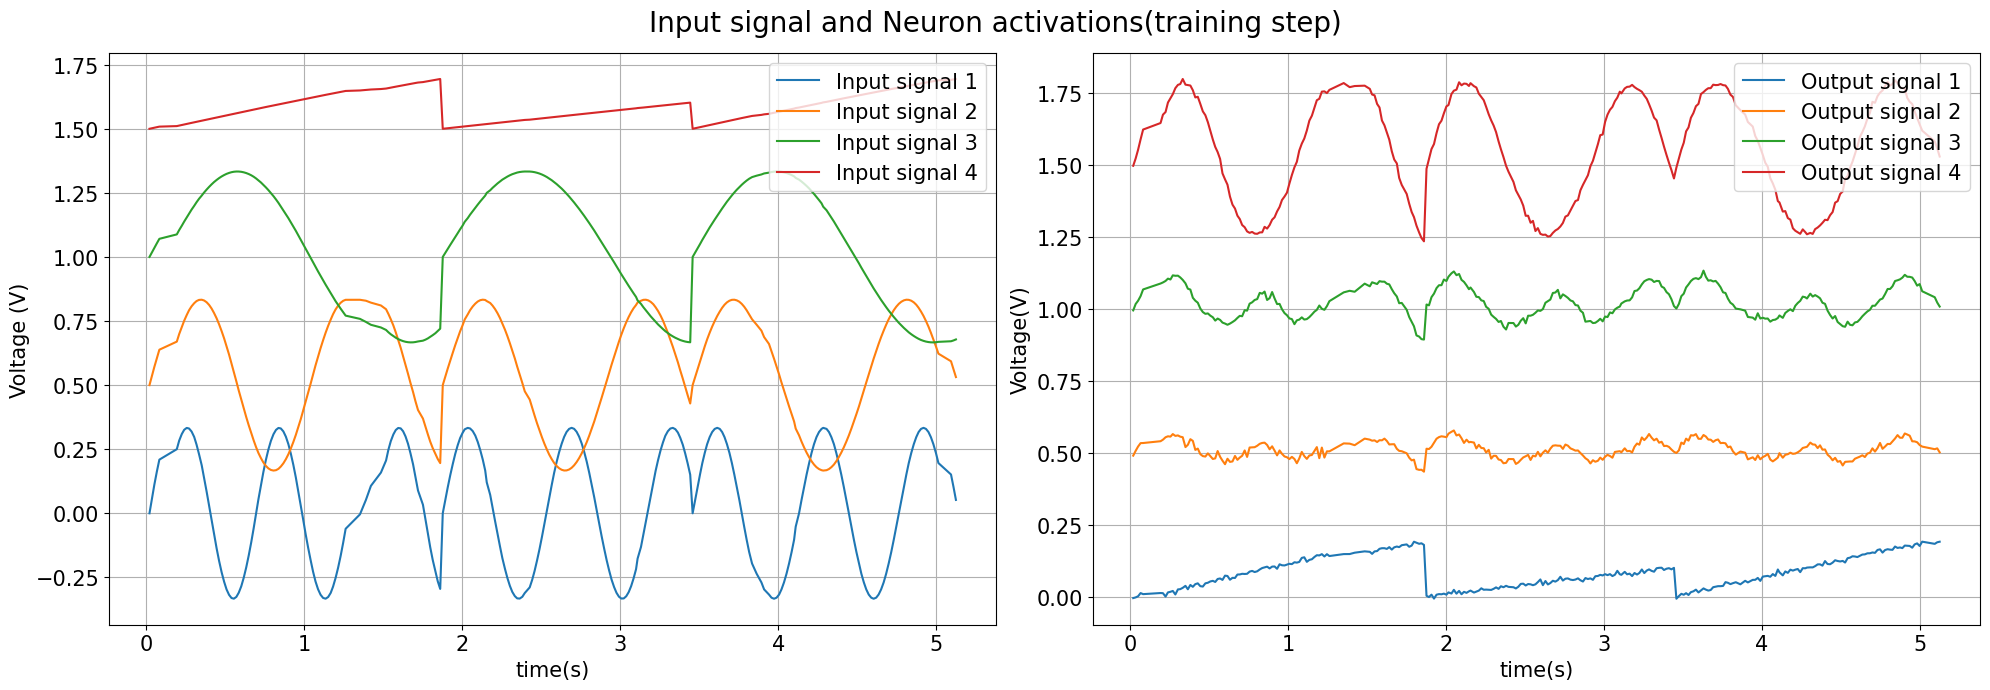

In [108]:

limit = 300
scaling_factor = 1
spacing = 0.5



fig,ax = plt.subplots(1,2,figsize=(20, 7))
fig.suptitle('Input signal and Neuron activations(training step)',fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=15)

ax[1].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ai_1_A'][0:limit]*scaling_factor),label='Output signal 1')
ax[1].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ai_2_A'][0:limit]*scaling_factor) + spacing,label='Output signal 2')
ax[1].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ai_3_A'][0:limit]*scaling_factor) + spacing*2,label='Output signal 3')
ax[1].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ai_4_A'][0:limit]*scaling_factor) + spacing*3,label='Output signal 4')

ax[1].grid()
ax[1].set_xlabel('time(s)',size=15)

ax[1].set_ylabel('Voltage(V)',size=15)
ax[1].legend(loc='upper right',fontsize=15)


ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ao_1_V'][0:limit]),label="Input signal 1")
ax[0].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ao_2_V'][0:limit]*scaling_factor) + spacing,label="Input signal 2")
ax[0].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ao_3_V'][0:limit]*scaling_factor) + spacing*2,label="Input signal 3")
ax[0].plot(reservoir_states_train['time'][0:limit],(reservoir_states_train['Ao_4_V'][0:limit]*scaling_factor) + spacing*3,label="Input signal 4")
ax[0].grid()
ax[0].set_xlabel('time(s)',size=15)
ax[0].set_ylabel('Voltage (V)',size=15)
ax[0].legend(loc='upper right',fontsize=15)

plt.tight_layout()
plt.savefig(f"Input_signal_and_neuron_activations_{experiment_train}.pdf",format='pdf')
plt.show()



plt.show()

In [109]:
#To build the extended state matrix(Z), we need to concatenate the reservoir states and inputs row-wise(one row bellow each other). Your dataset is already in this format(row_wise) but you need to reajust the columns.
X_train = reservoir_states_train.iloc[:,[0,1,2,3]].to_numpy()

print(X_train)

[[-0.00379245 -0.00878614 -0.00411463 -0.00153724]
 [-0.00137616  0.00796686  0.01811531  0.02391442]
 [ 0.00248992  0.02278682  0.02939136  0.05387651]
 ...
 [ 0.14666234 -0.040198   -0.08498005 -0.24300591]
 [ 0.15278362 -0.05066863 -0.09496741 -0.21819859]
 [ 0.19531046 -0.02859978 -0.07144878 -0.18807541]]


In [110]:
#Linear regression with the train states matrix(Z) and the target matrix(Yt)(Ridge regression)

alpha = 1e-3
T_washout = 0     #discarding 10% of initial points

# drop states during the initial washout period of each time series
X_washout = X_train.reshape((u_train.shape[0], u_train.shape[1], -1))[:, T_washout:, :]
X = np.concatenate(X_washout)
Y = np.concatenate(y_train[:, T_washout:, :])
# state correlation matrix
R = X.T @ X
# state-output cross-correlation matrix
P = X.T @ Y
# ridge regression: state -> output
wout = np.linalg.inv((R + alpha * np.eye(X_train.shape[1]))) @ P


print(wout)

[[ 0.89941756  0.98867369  0.10150177]
 [-2.82004551 -0.2675381  -2.26695398]
 [ 3.24716536  1.33230409  2.7568648 ]
 [ 0.0427998   0.23263638  0.2359824 ]]


In [111]:
print(wout.shape)

(4, 3)


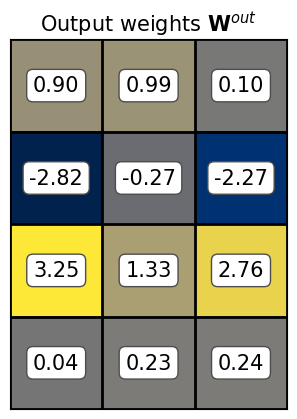

In [112]:
def plot_outuput_weigh_matrix(matrix, title=r'Output weights $\mathbf{W}^{out}$', cmap='cividis'):
    plt.imshow(matrix, cmap=cmap) # imshow


    plt.title(title,fontsize=15)
    plt.vlines([-0.5,0.5,1.5,2.5],ymax=3.5,ymin=-0.5,colors='black',linewidth=2)
    plt.hlines([-0.5,0.5,1.5,2.5,3.5],xmax=2.5,xmin=-0.5,colors='black',linewidth=2)

    plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # labels along the bottom edge are off

    # tick_marks = np.arange(len(matrix.columns))
    # plt.xticks(tick_marks, matrix.columns, rotation=45,fontsize = 15)
    # plt.yticks(tick_marks, matrix.index,fontsize = 15)
    # plt.tight_layout()
    # plt.ylabel(matrix.index.name,fontsize=15)
    # plt.xlabel(matrix.columns.name,fontsize=15)
    for (i, j), z in np.ndenumerate(matrix):
        plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)


    plt.savefig(f'wout_matrix_{experiment_train}.pdf',format='pdf')

plot_outuput_weigh_matrix(wout)

In [113]:
np.savetxt(f'weight_output_{experiment_train}.txt',delimiter='\t',X=wout)



In [114]:
#computing predicted values
y_pred_train = X_train @ wout


In [115]:
def accuracy_elementwise(ypred, ytrue):
    # compute accuracy at each time step
    yp = ypred.reshape(-1, ytrue.shape[2]).argmax(axis=1)         #argmax(axis =1) is the "winner takes all" approach from the paper "hands on Reservoir computing"
    yt = ytrue.reshape(-1, ytrue.shape[2]).argmax(axis=1)
    return np.sum(yp == yt) / yp.shape[0]



print(f'Training accuracy: {accuracy_elementwise(y_pred_train, y_train):.2%} (per time step)')

Training accuracy: 43.65% (per time step)


In [116]:
def accuracy(ypred, ytrue):
    # compute accuracy by averaging the predicted class over the whole time series
    yp = ypred.reshape(ytrue.shape).mean(axis=1).argmax(axis=1)
    yt = ytrue[:,0,:].argmax(axis=1)
    return np.sum(yp == yt) / yp.shape[0]

print(f'Training accuracy: {accuracy(y_pred_train, y_train):.2%} (per time series)')

Training accuracy: 47.50% (per time series)


Predicted  0   1   2
Actual              
0          5  35   0
1          2  38   0
2          9  17  14


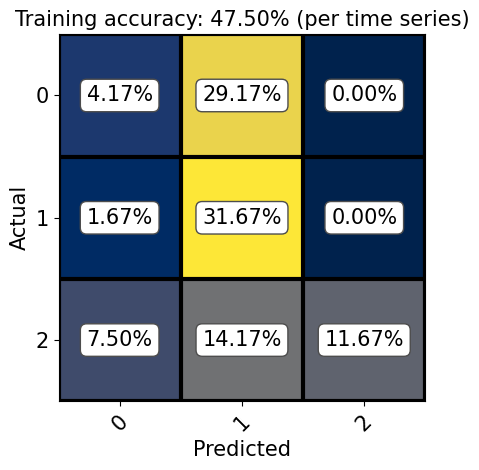

In [117]:
#printing confusion matrix



y_pred_train_series = pd.Series(y_pred_train.reshape(y_train.shape).mean(axis=1).argmax(axis=1), name='Predicted')
y_train_series = pd.Series(y_train[:,0,:].argmax(axis=1), name='Actual')


def plot_confusion_matrix_train(df_confusion, title=(f'Training accuracy: {accuracy(y_pred_train, y_train):.2%} (per time series)'), cmap='cividis'):
    if df_confusion.shape[1] == 1:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=0.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_train}.pdf',format='pdf')

    if df_confusion.shape[1] == 2:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=1.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_train}.pdf',format='pdf')


    if df_confusion.shape[1] == 3:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5,1.5,2.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=2.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_train}.pdf',format='pdf')



df_confusion = pd.crosstab(y_train_series, y_pred_train_series)
print(df_confusion)

plot_confusion_matrix_train(df_confusion*100/len(u_train))


In [118]:
u_test_signal = np.concatenate(u_test)

In [119]:
encoding = 'No_Encoding'
date_stamp = time.strftime('%Y_%m_%d')
dataset = 'iris_dataset'
sample = "7-2_6-3_8-1_5-4_FIBER_LICLO4_ELECTROLYTE_RES_CHIP_0010_CE4_#3"

experiment_test = f"{dataset}_test_states_{sample}_encoding={encoding}_{date_stamp}"


In [120]:

print(experiment_test)

iris_dataset_test_states_7-2_6-3_8-1_5-4_FIBER_LICLO4_ELECTROLYTE_RES_CHIP_0010_CE4_#3_encoding=No_Encoding_2025_02_21


In [121]:
exp_test = load_or_create_experiment(
    experiment_name=experiment_test, sample_name=sample)

In [122]:
context_meas = Measurement(exp=exp_test, name=f'{experiment_test}')
#Registering ai channels parameters
context_meas.register_parameter(ai_1_6002)
context_meas.register_parameter(ai_2_6002)
context_meas.register_parameter(ai_3_6002)
context_meas.register_parameter(ai_4_6002)
# context_meas.register_parameter(ai_5_6002)
# context_meas.register_parameter(ai_6_6002)
# context_meas.register_parameter(ai_7_6002)
context_meas.register_parameter(Ao_1)
context_meas.register_parameter(Ao_2)
context_meas.register_parameter(Ao_3)
context_meas.register_parameter(Ao_4)
# context_meas.register_parameter(entry)
context_meas.register_parameter(time_parameter)


In [123]:
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)



agilent_dual_channel.ch1.output('ON')
agilent_dual_channel.ch2.output('ON')
with context_meas.run(write_in_background=False) as datasaver:  
        time_parameter.reset_clock() 
        for i in u_test_signal:
                
              
                
                agilent_dual_channel.ch1.offset(i[0])     #Ao_1
                agilent_dual_channel.ch2.offset(i[1])     #Ao_2
                dac_ao_6001.voltage_0.set(i[2])           #Ao_3
                dac_ao_6001.voltage_1.set(i[3])           #Ao_4
                voltages = daq_ai_6002.voltage()

                now = time_parameter() 
                datasaver.add_result((Ao_1,i[0]),(Ao_2,i[1]),(Ao_3,i[2]),(Ao_4,i[3]),(ai_1_6002,voltages[0]),(ai_2_6002,voltages[1]),(ai_3_6002,voltages[2]),
                                (ai_4_6002,voltages[3]),(time_parameter,now))



                        
        dataset = datasaver.dataset
    
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)

agilent_dual_channel.ch1.output('OFF')
agilent_dual_channel.ch2.output('OFF')

Starting experimental run with id: 871. 


In [124]:
experiments()
last_run_id = dataset.captured_run_id
print(last_run_id)
reservoir_states_test=load_by_run_spec(captured_run_id=last_run_id).to_pandas_dataframe()
print(reservoir_states_test)

[iris_dataset_train_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13#no_fiber_no_electrolyte_res_chip_0006_CE_04#1@c:\Users\laboratorio20\codigos_python\fiber_experiments\reservoir_iris\reservoirs_database_iris.db
 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 1-iris_dataset_train_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13-1-Ai_1_A,Ao_4_V,Ao_3_V,Ai_2_A,Ai_4_A,time,Ai_3_A,Ao_2_V,Ao_1_V-108000,
 iris_dataset_test_states_no_fiber_no_electrolyte_res_chip_0006_CE_04_2024_12_13#no_fiber_no_electrolyte_res_chip_0006_CE_04#2@c:\Users\laboratorio20\codigos_python\fiber_experiments\reservoir_iris\reservoirs_database_iris.db
 --------------------------------------------------------------------------------------------------------------------------------------------------------------------

871
        Ai_1_A    Ai_2_A    Ai_3_A    Ai_4_A    Ao_1_V    Ao_2_V    Ao_3_V  \
0     0.001684 -0.010880 -0.007820 -0.005887  0.000000  0.000000  0.000000   
1    -0.005242  0.014732  0.003618  0.033096  0.056278  0.038659  0.015702   
2     0.008772  0.017632  0.019404  0.029230  0.110940  0.076796  0.031369   
3     0.015216  0.031969  0.052427  0.097692  0.162417  0.113897  0.046967   
4     0.009417  0.045178  0.072724  0.132809  0.209230  0.149461  0.062460   
...        ...       ...       ...       ...       ...       ...       ...   
2995 -0.255732 -0.023928 -0.029727  0.122983 -0.315362  0.151330  0.155977   
2996 -0.240429 -0.016196 -0.015069  0.104297 -0.290061  0.122708  0.106981   
2997 -0.232052 -0.015069 -0.031983  0.079328 -0.254824  0.092997  0.055245   
2998 -0.220132 -0.016679 -0.024573  0.056293 -0.210857  0.062460  0.002094   
2999 -0.200318 -0.013297 -0.025217  0.033902 -0.159666  0.031369 -0.051110   

        Ao_4_V       time  
0     0.000000   0.027677  
1  

In [125]:
reservoir_states_test.to_csv(f'{experiment_test}.txt',sep='\t',decimal='.')

In [126]:
X_test = reservoir_states_test.iloc[:,[0,1,2,3]].to_numpy()

Text(0.5, 0.98, 'Input signal and Neuron activations(testing step)')

Text(0.5, 0, 'time(s)')

Text(0, 0.5, 'Voltage(V)')

Text(0.5, 0, 'time(s)')

Text(0, 0.5, 'Voltage (V)')

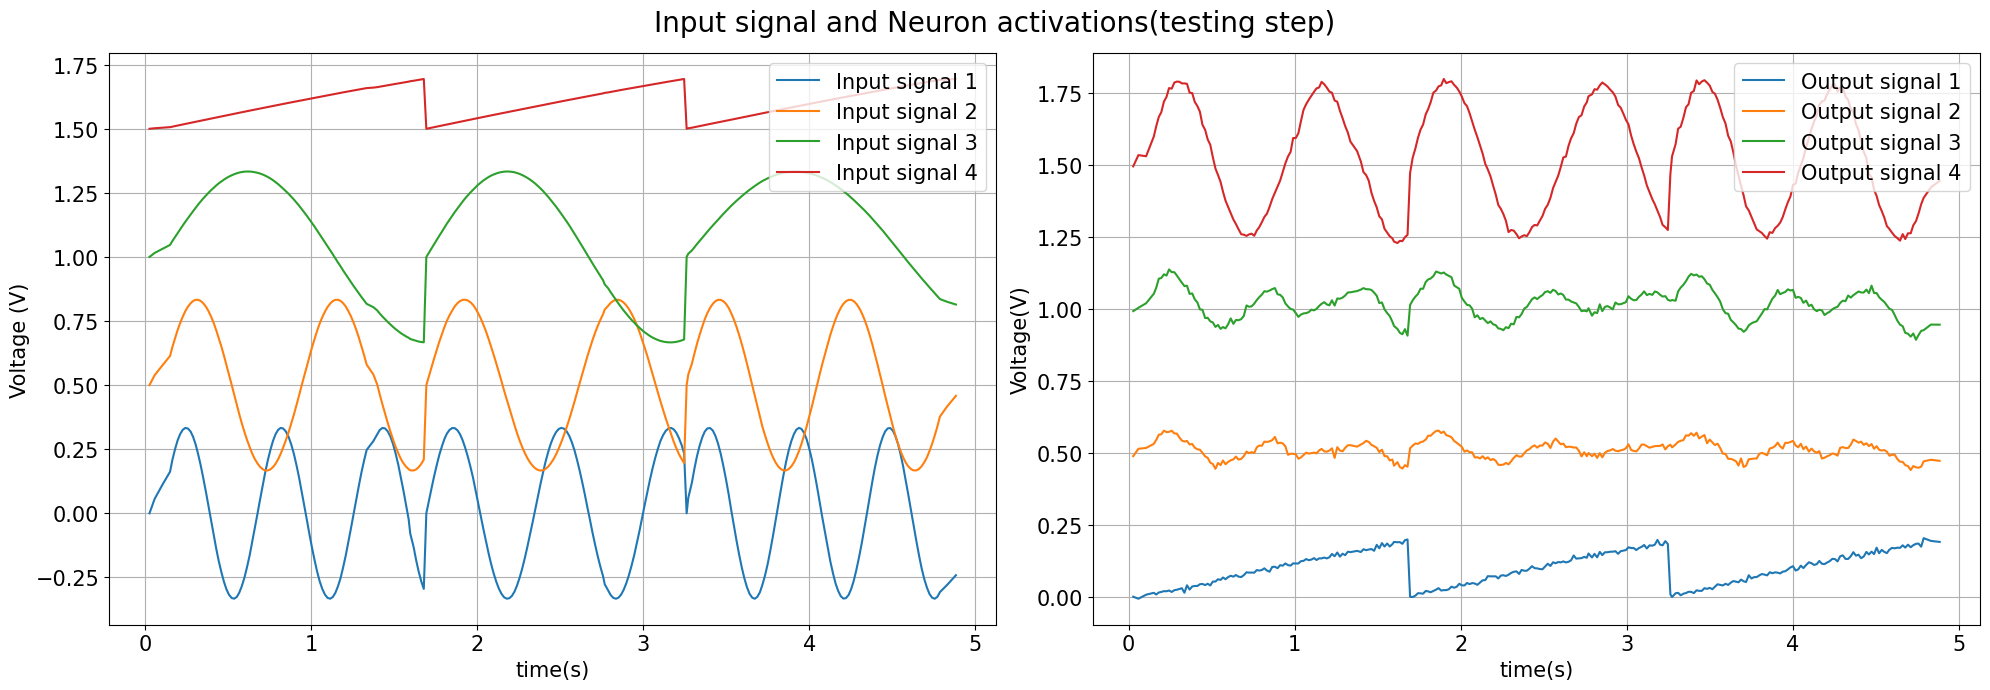

In [127]:
limit = 300
scaling_factor = 1
spacing = 0.5



fig,ax = plt.subplots(1,2,figsize=(20, 7))
fig.suptitle('Input signal and Neuron activations(testing step)',fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=15)

ax[1].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ai_1_A'][0:limit]*scaling_factor),label='Output signal 1')
ax[1].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ai_2_A'][0:limit]*scaling_factor) + spacing,label='Output signal 2')
ax[1].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ai_3_A'][0:limit]*scaling_factor) + spacing*2,label='Output signal 3')
ax[1].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ai_4_A'][0:limit]*scaling_factor) + spacing*3,label='Output signal 4')

ax[1].grid()
ax[1].set_xlabel('time(s)',size=15)

ax[1].set_ylabel('Voltage(V)',size=15)
ax[1].legend(loc='upper right',fontsize=15)


ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ao_1_V'][0:limit]),label="Input signal 1")
ax[0].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ao_2_V'][0:limit]*scaling_factor) + spacing,label="Input signal 2")
ax[0].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ao_3_V'][0:limit]*scaling_factor) + spacing*2,label="Input signal 3")
ax[0].plot(reservoir_states_test['time'][0:limit],(reservoir_states_test['Ao_4_V'][0:limit]*scaling_factor) + spacing*3,label="Input signal 4")
ax[0].grid()
ax[0].set_xlabel('time(s)',size=15)
ax[0].set_ylabel('Voltage (V)',size=15)
ax[0].legend(loc='upper right',fontsize=15)

plt.tight_layout()
plt.savefig(f"Input_signal_and_neuron_activations_{experiment_test}.pdf",format='pdf')
plt.show()



plt.show()


In [128]:
y_pred_test = X_test @ wout

In [129]:
print(f'Testing accuracy:  {accuracy_elementwise(y_pred_test, y_test):.2%} (per time step)')
print(f'Testing accuracy:  {accuracy(y_pred_test, y_test):.2%} (per time series)')

Testing accuracy:  43.53% (per time step)
Testing accuracy:  40.00% (per time series)


Predicted  0   1  2
Actual             
0          1   9  0
1          0  10  0
2          3   6  1


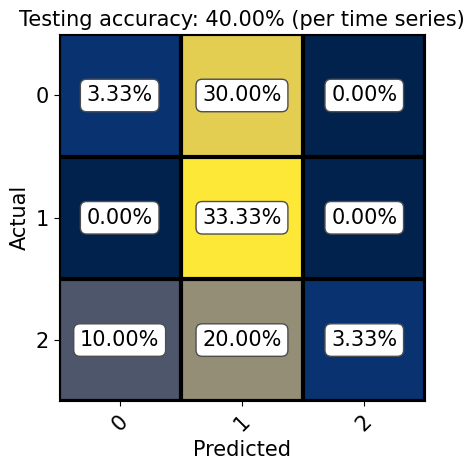

In [130]:
y_pred_test_series = pd.Series(y_pred_test.reshape(y_test.shape).mean(axis=1).argmax(axis=1), name='Predicted')
y_test_series = pd.Series(y_test[:,0,:].argmax(axis=1), name='Actual')



def plot_confusion_matrix_test(df_confusion, title=f'Testing accuracy: {accuracy(y_pred_test, y_test):.2%} (per time series)', cmap='cividis'):

    if df_confusion.shape[1] == 1:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=0.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_test}.pdf',format='pdf')

    if df_confusion.shape[1] == 2:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=1.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_test}.pdf',format='pdf')


    if df_confusion.shape[1] == 3:

        plt.imshow(df_confusion, cmap=cmap) # imshow

        plt.title(title,fontsize=15)
        plt.vlines([-0.5,0.5,1.5,2.5],ymax=2.5,ymin=-0.5,colors='black',linewidth=3)
        plt.hlines([-0.5,0.5,1.5,2.5],xmax=2.5,xmin=-0.5,colors='black',linewidth=3)
        tick_marks_x = np.arange(df_confusion.shape[1])
        tick_marks_y = np.arange(df_confusion.shape[0])
        plt.xticks(tick_marks_x, df_confusion.columns, rotation=45,fontsize = 15)
        plt.yticks(tick_marks_y, df_confusion.index,fontsize = 15)
        plt.ylabel(df_confusion.index.name,fontsize=15)
        plt.xlabel(df_confusion.columns.name,fontsize=15)
    
        for (i, j), z in np.ndenumerate(df_confusion):
            plt.text(j, i, '{:0.2f}%'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'),fontsize=15)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{experiment_test}.pdf',format='pdf')

        


df_confusion = pd.crosstab(y_test_series, y_pred_test_series)
print(df_confusion)



plot_confusion_matrix_test(df_confusion*100/len(u_test))

In [131]:
dac_ao_6001.voltage_0(0)
dac_ao_6001.voltage_1(0)
agilent_dual_channel.ch1.offset(0)
agilent_dual_channel.ch2.offset(0)

agilent_dual_channel.ch1.output('OFF')
agilent_dual_channel.ch2.output('OFF')